# DSO 522: Applied Time Series Analysis for Forecasting

## Week 9: ARIMA Models (part I)

### Fall 2024

#### Instructor: Dr. Matteo Sesia

<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

## ARIMA models

- One of the most widely applied approaches for time series forecasting, next to Exponential Smoothing.

- Exponential Smoothing focuses on describing trend and seasonality.

- ARIMA models focus on describing **autocorrelations**.

- Before introducing ARIMA models, we need to discuss two key concepts:
  - Stationarity
  - Differencing techniques

##  Stationarity and differencing

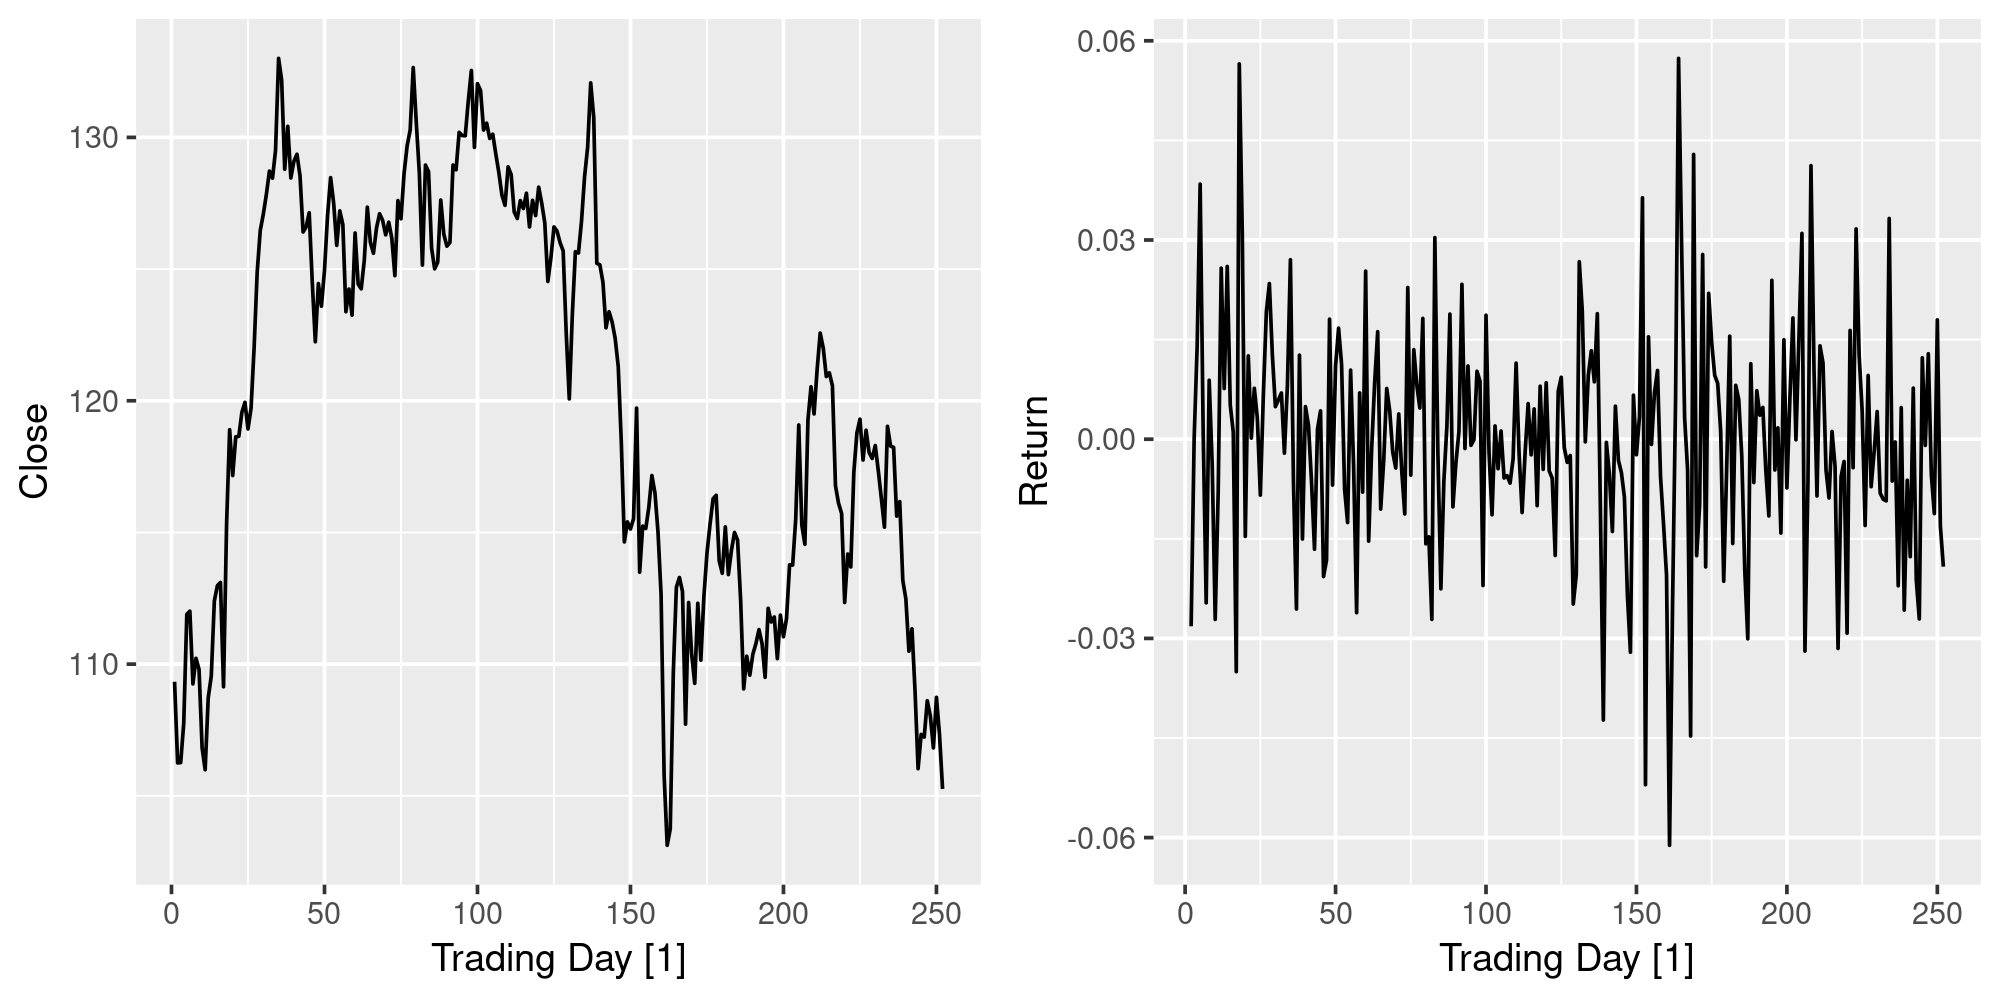

In [2]:
aapl_2015 <- gafa_stock |> 
    filter(Symbol %in% c("AAPL"), year(Date) == 2015) |>
    mutate(`Trading Day` = row_number()) |>
    as_tsibble(index=`Trading Day`, regular=TRUE)

plot1 <- aapl_2015 |> 
    autoplot(Close)
plot2 <- aapl_2015 |> 
    mutate(Return = (Close-lag(Close))/lag(Close)) |>
    filter(!is.na(Return)) |>
    autoplot(Return)
grid.arrange(plot1, plot2, ncol = 2)

## Stationarity

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed.


<p align="center">
  <img src="img/stationary-1.png" alt="Stationarity" width="600"/>
</p>

## Differencing

- Transformations such as logarithms can help to stabilise the variance of a time series. 

- Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

The differenced series is the change between consecutive observations in the original series, and can be written as 
$$y'_t = y_t - y_{t-1}.$$

## Example: Changes in Apple stock price

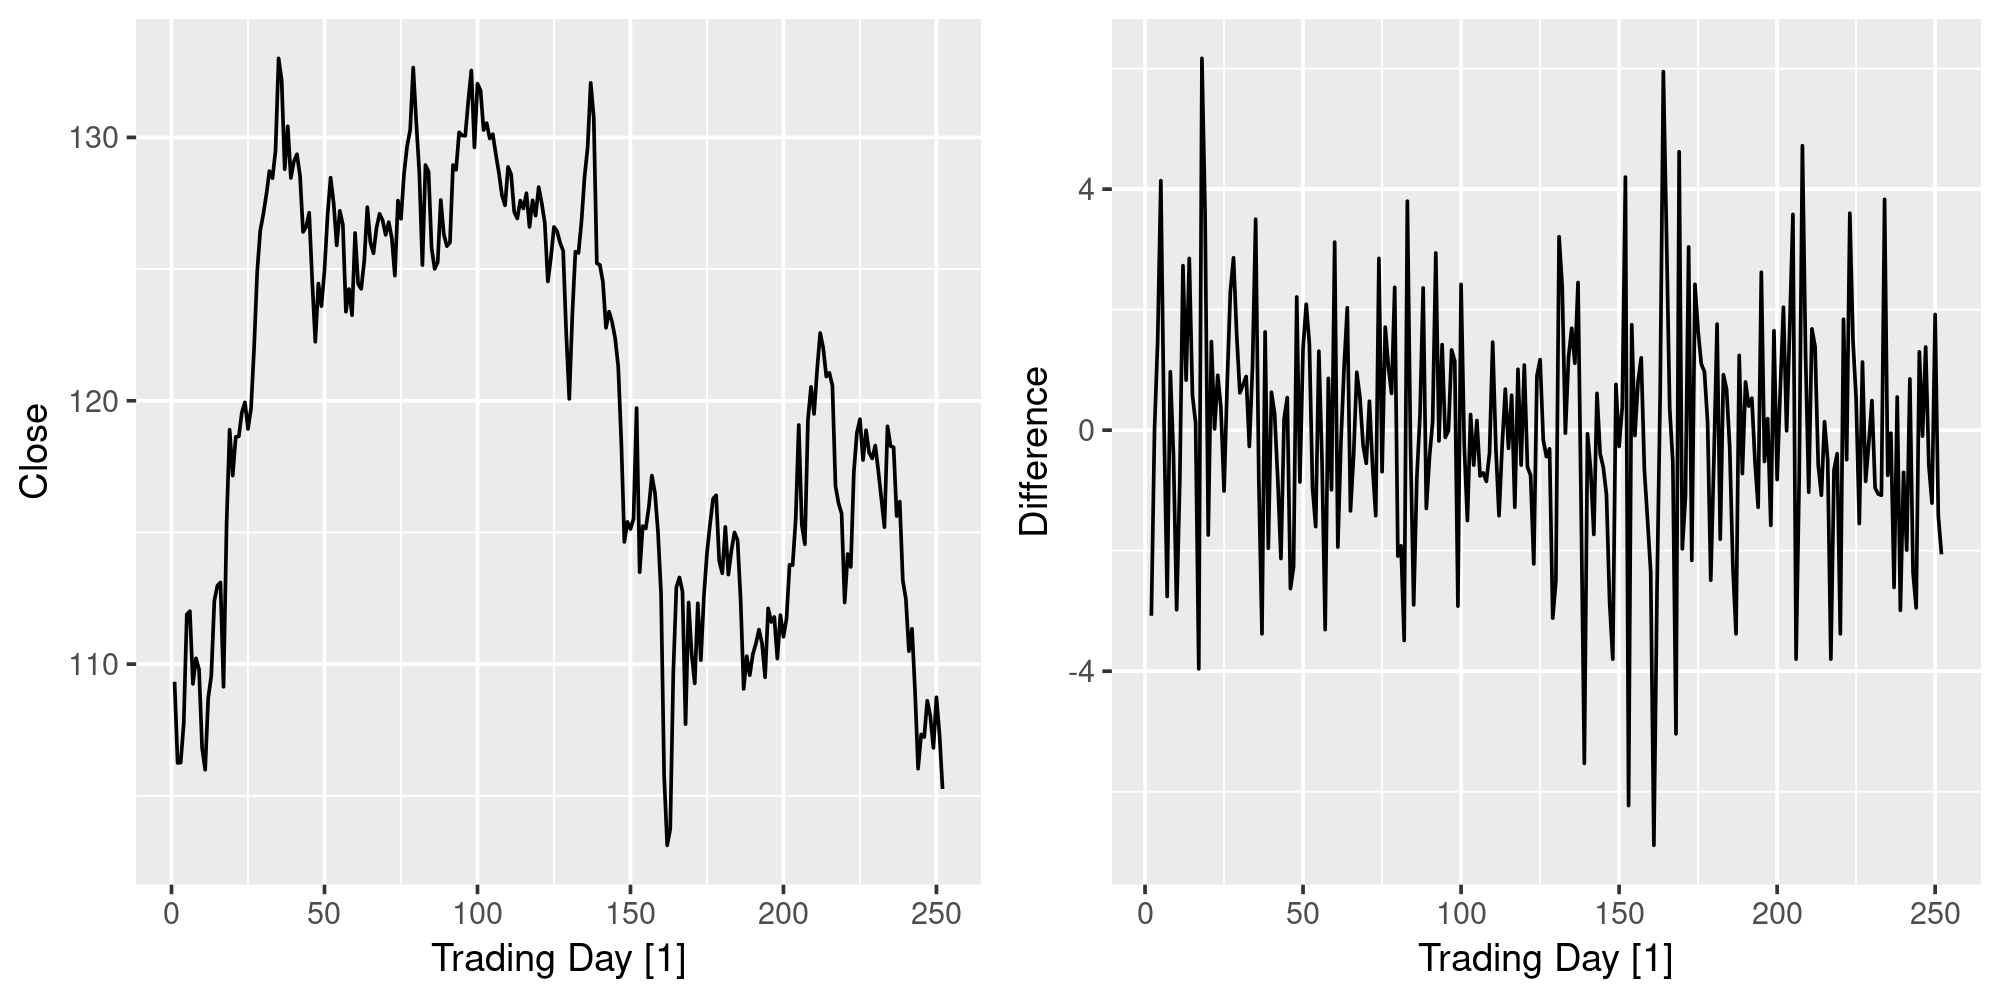

In [3]:
plot1 <- aapl_2015 |> 
    autoplot(Close)

plot2 <- aapl_2015 |> 
    mutate(Difference = difference(Close)) |>
    filter(!is.na(Difference)) |>
    autoplot(Difference)

grid.arrange(plot1, plot2, ncol = 2)

## Example: Changes in Apple stock price (ACF)

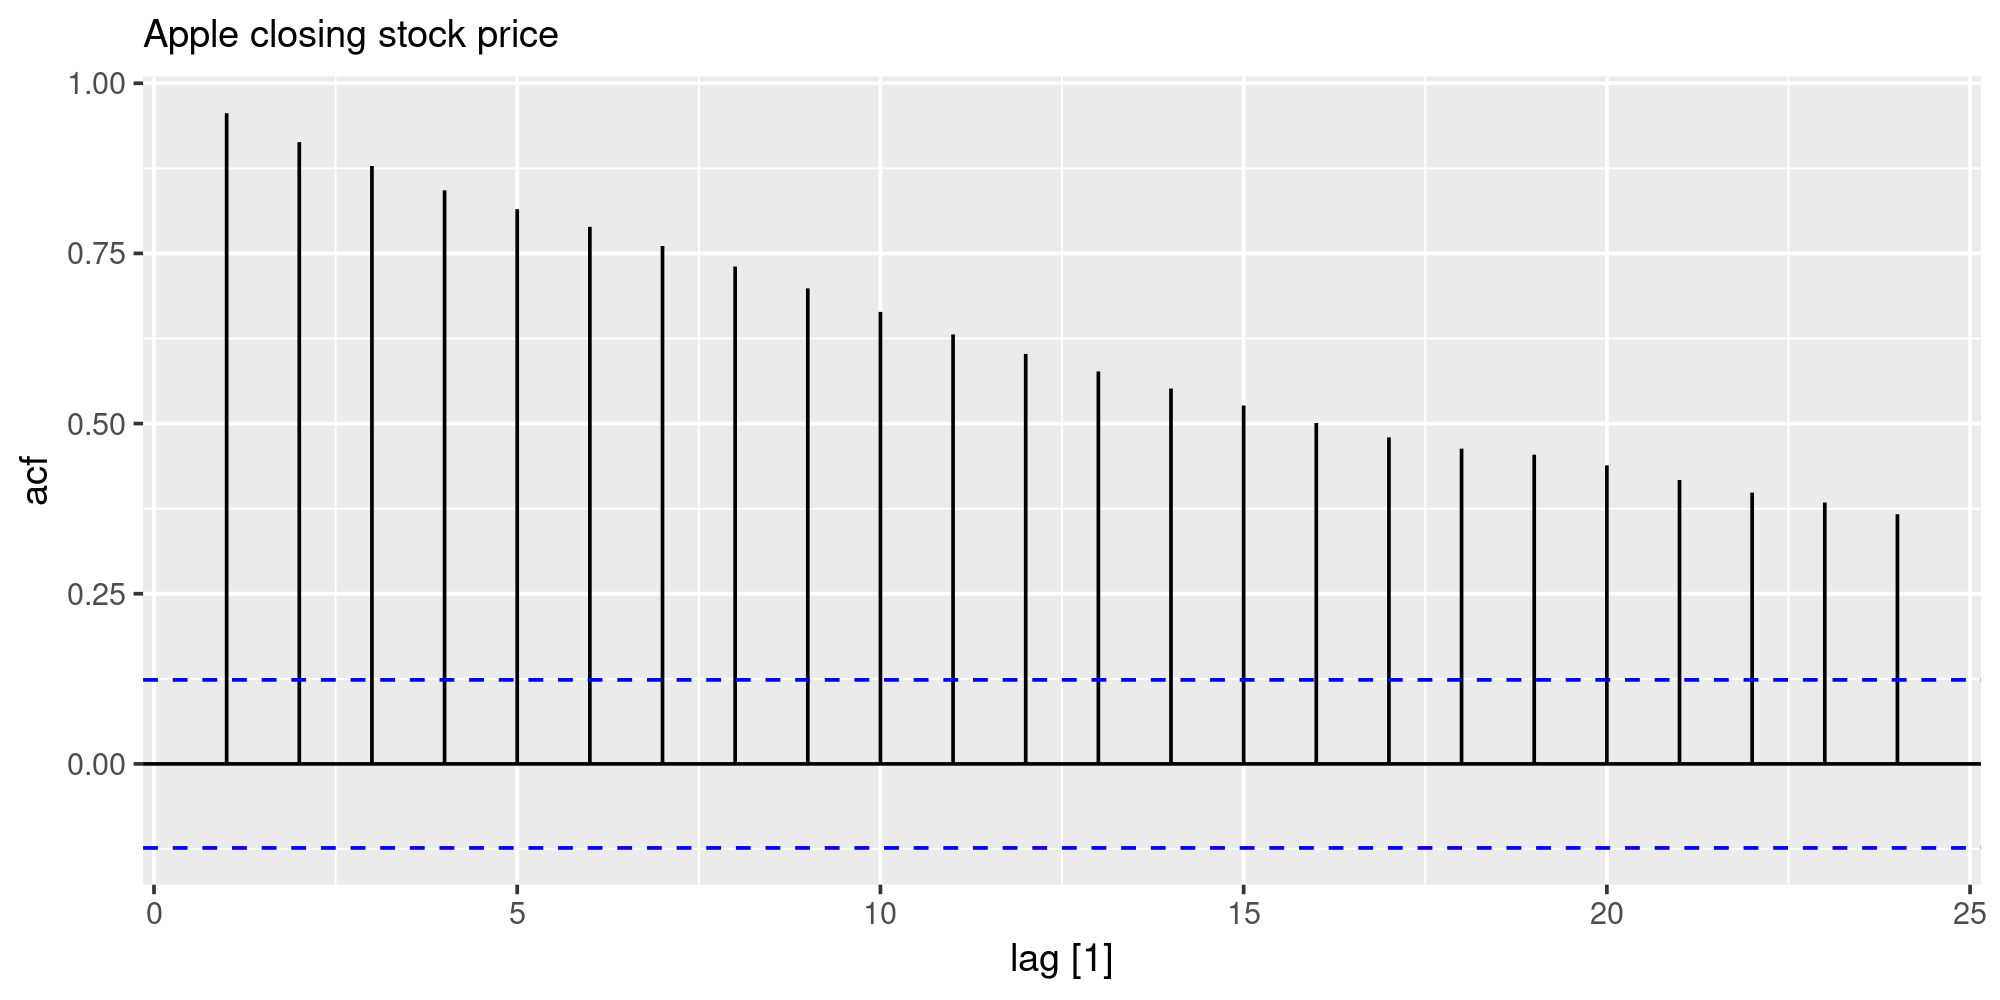

In [4]:
aapl_2015 |>
    ACF(Close) |>
    autoplot() + 
        labs(subtitle = "Apple closing stock price")

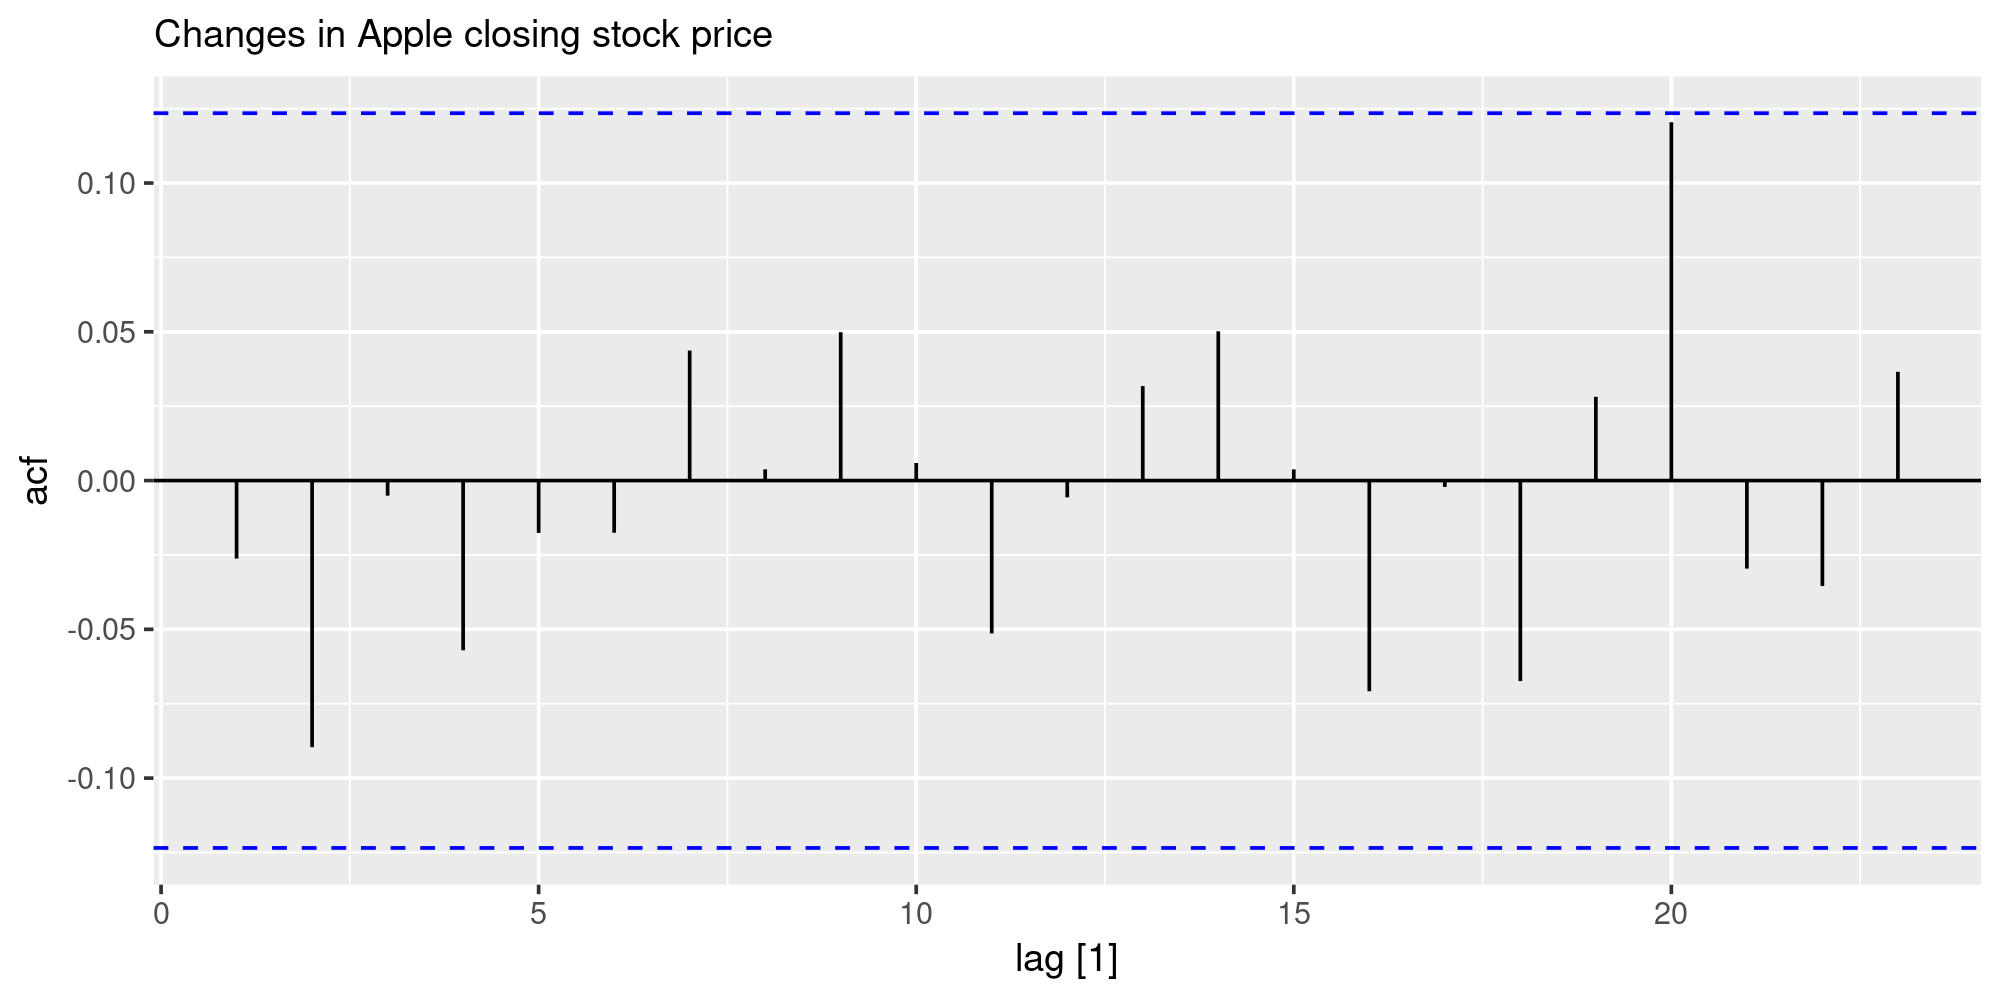

In [5]:
aapl_2015 |>
    mutate(Difference = difference(Close)) |>
    ACF(Difference) |>
    autoplot() + 
        labs(subtitle = "Changes in Apple closing stock price")

## Random walk model

The “random walk” model is:
$$y_t = y_{t-1} + \varepsilon_t,$$
where $\varepsilon_t$ denotes white noise.

Differencing a random walk gives:
$$y'_t = y_t - y_{t-1} = \varepsilon_t,$$

## What do random walks look like?

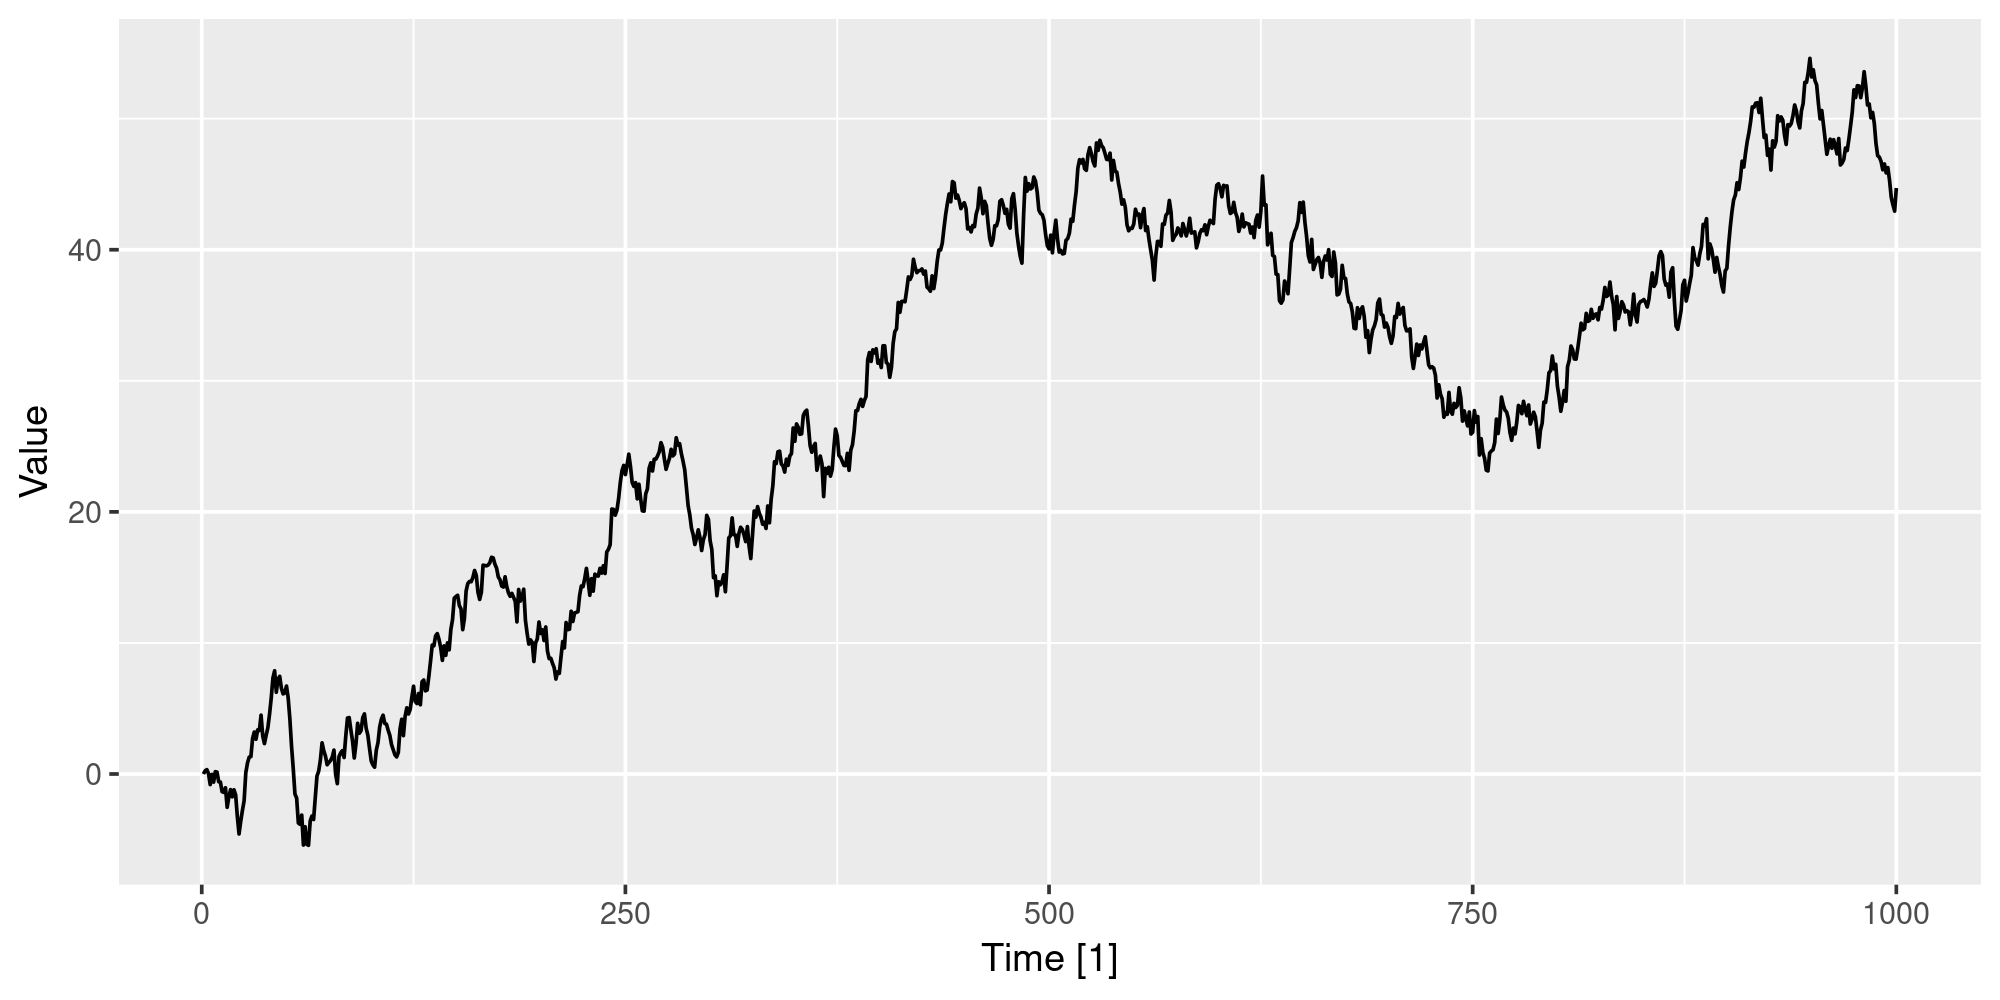

In [6]:
generate_random_walk <- function(n) {
    rw <- tibble(Time=1:n, Value=rep(0,n))
    for(i in 2:n) {
        rw$Value[i] = rw$Value[i-1] + rnorm(1)
    }
    rw <- rw |> as_tsibble(index=Time)
    return(rw)
}

rw <- generate_random_walk(1000) 
rw |> autoplot(Value)

## Second-order differencing

Occasionally the differenced data will not appear to be stationary and it may be necessary to difference the data a second time to obtain a stationary series: 
\begin{align*}
  y''_{t}  &=  y'_{t}  - y'_{t - 1} \\
           &= (y_t - y_{t-1}) - (y_{t-1}-y_{t-2})\\
           &= y_t - 2y_{t-1} +y_{t-2}.
\end{align*}

In practice, it is almost never necessary to go beyond second-order differences.

## Second-order differencing (example)

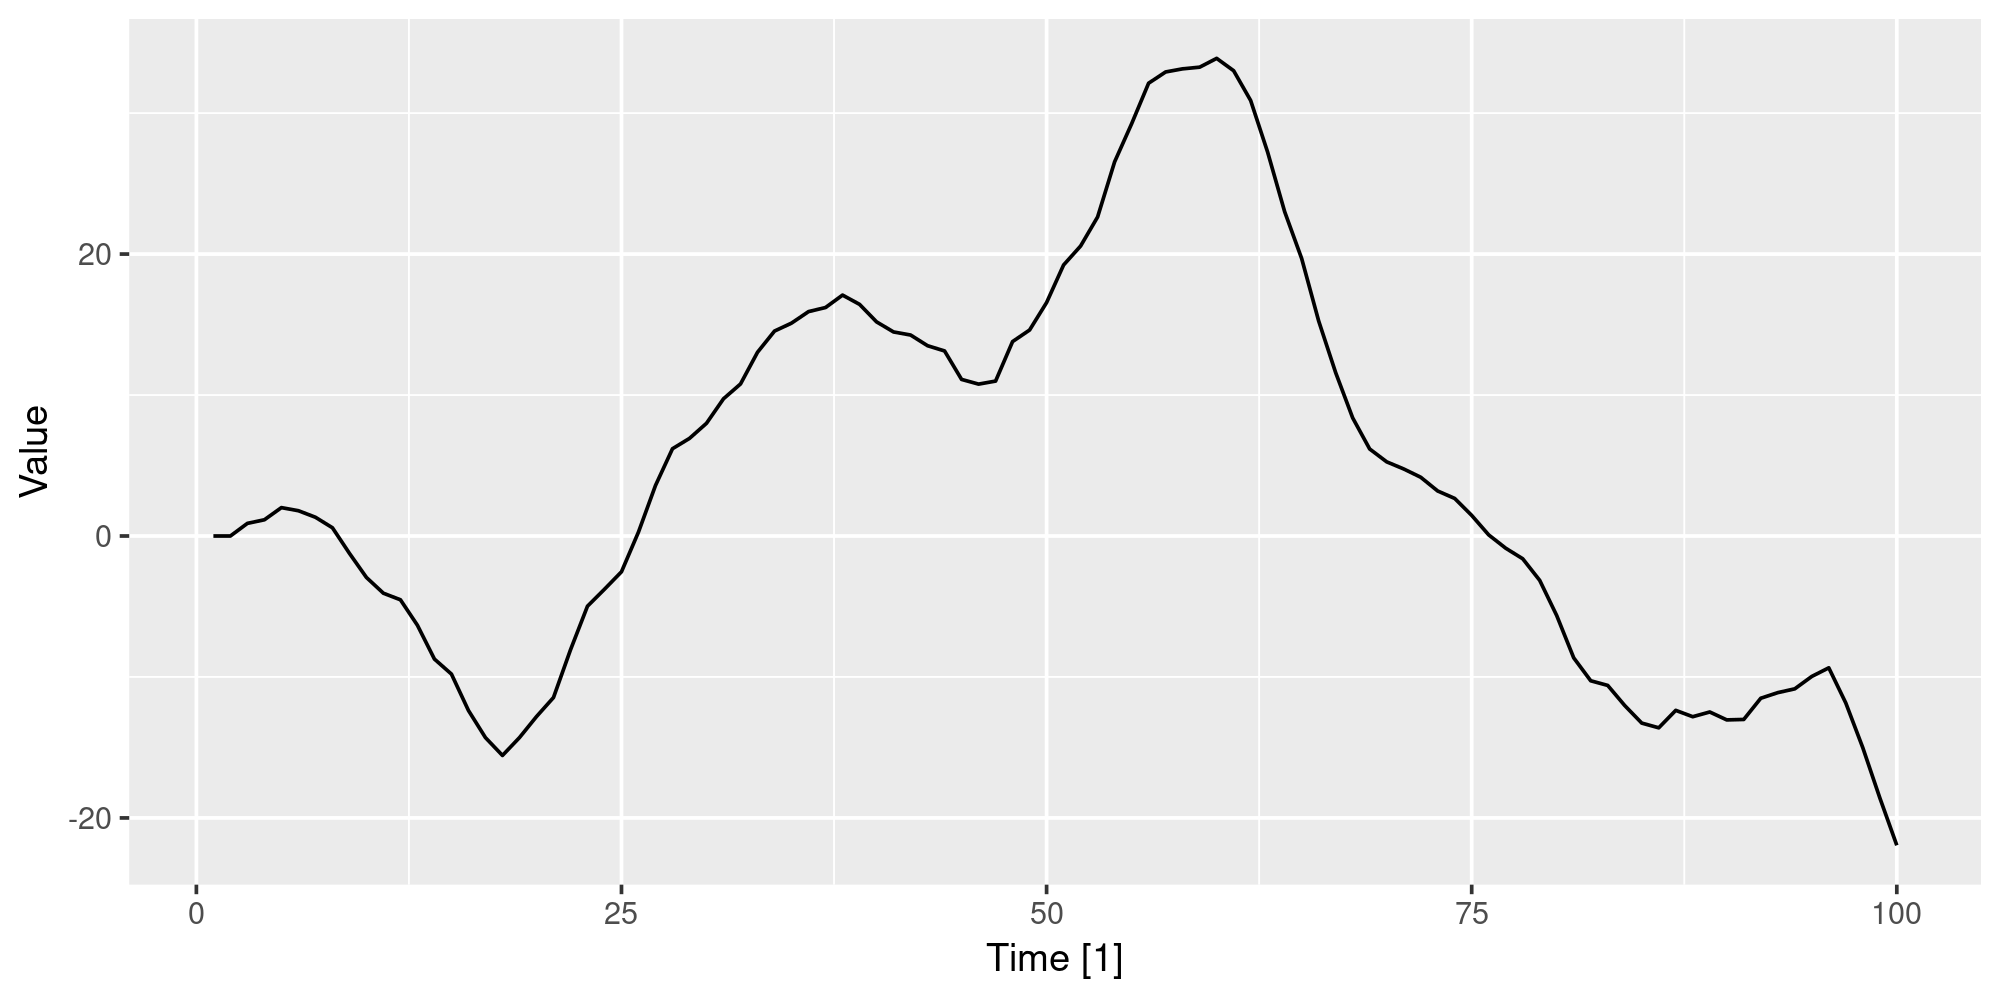

In [7]:
generate_strange_walk <- function(n) {
    rw <- tibble(Time=1:n, Value=rep(0,n))
    for(i in 3:n) {
        rw$Value[i] = rw$Value[i-1] + 
            0.75*(rw$Value[i-1]-rw$Value[i-2])+ rnorm(1)
    }
    rw <- rw |> as_tsibble(index=Time)
    return(rw)
}

rw2 <- generate_strange_walk(100) 
rw2 |> autoplot(Value)

## Seasonal differencing

A seasonal difference is the difference between an observation and the previous observation from the same season.
$$
y'_t = y_t - y_{t-m},
$$
where $m$ is the number of seasons. 

These are also called "lag-$m$ differences", as we subtract the observation after a lag of $m$ periods.

If seasonally differenced data appear to be white noise, then an appropriate model for the original data is 
$$y_t = y_{t-m}+\varepsilon_t.$$

## Example: Souvenir sales

Sometimes it is necessary to take both a seasonal difference and a first difference to obtain stationary data. 

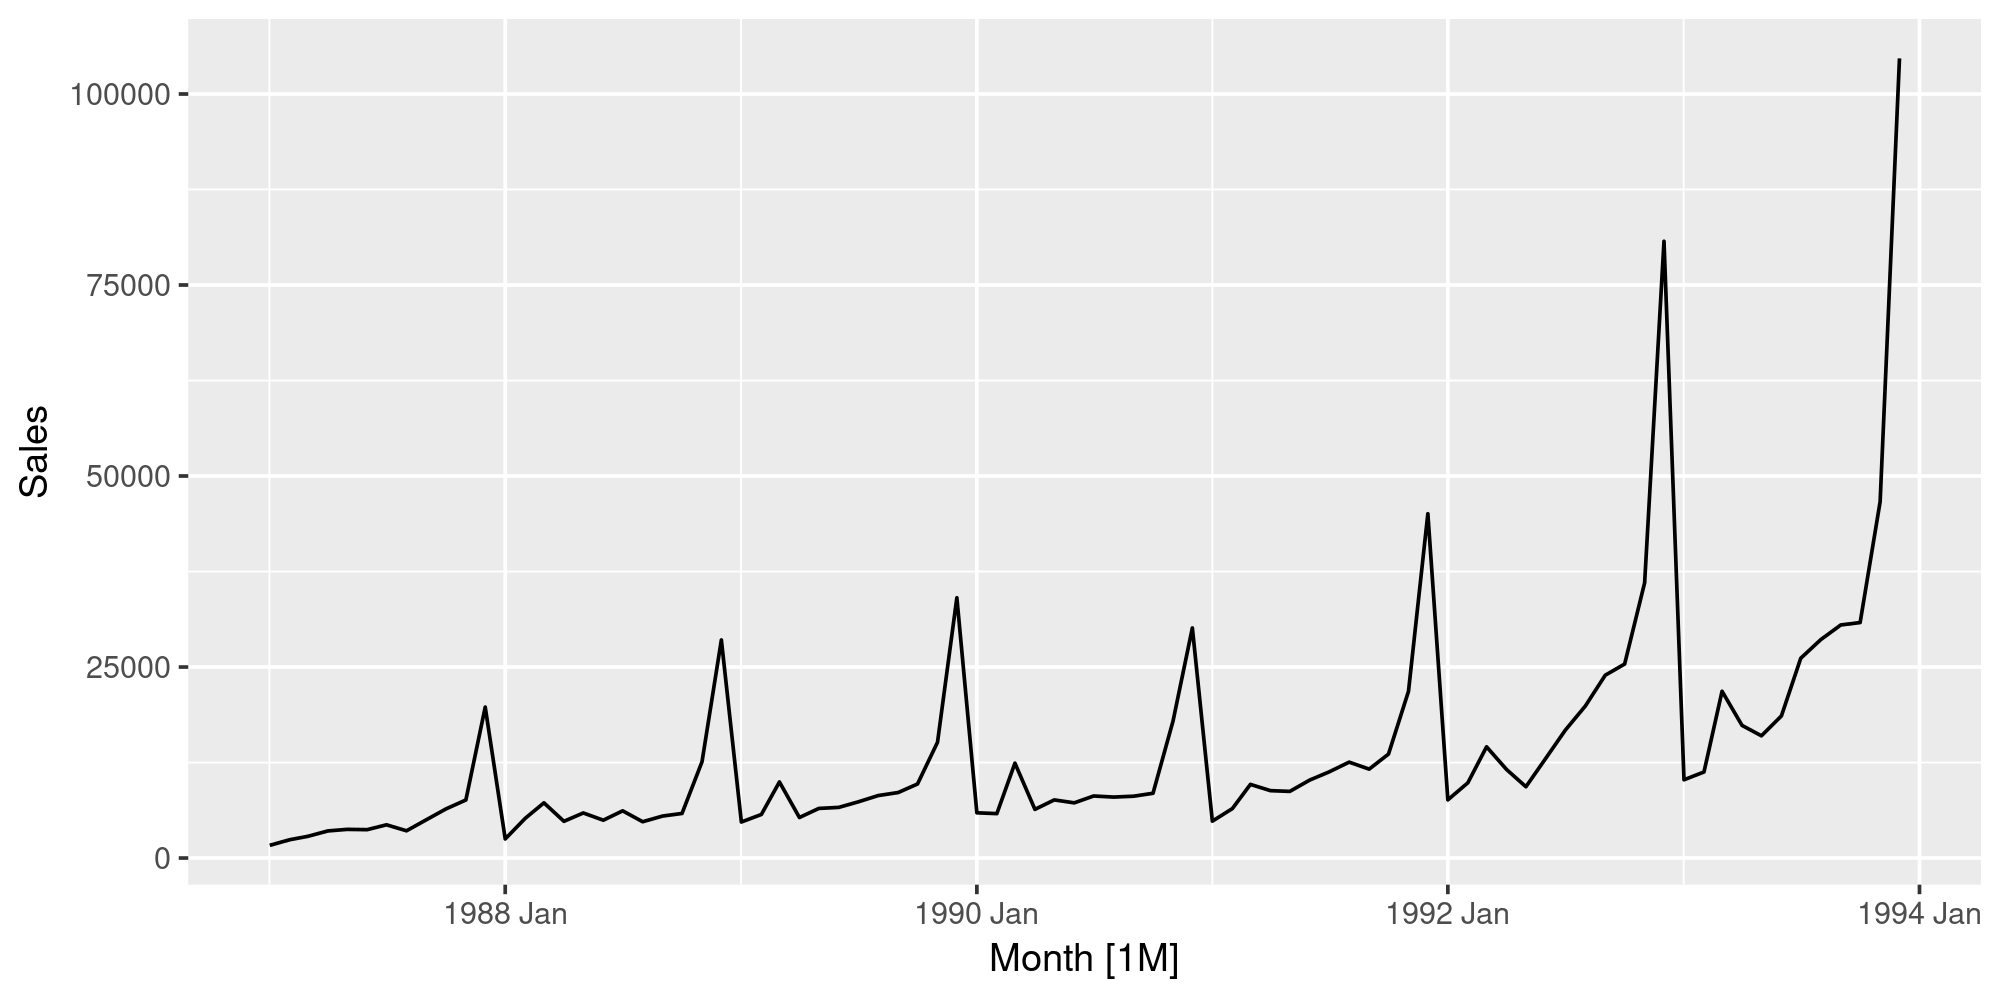

In [8]:
souvenirs |> autoplot(Sales)

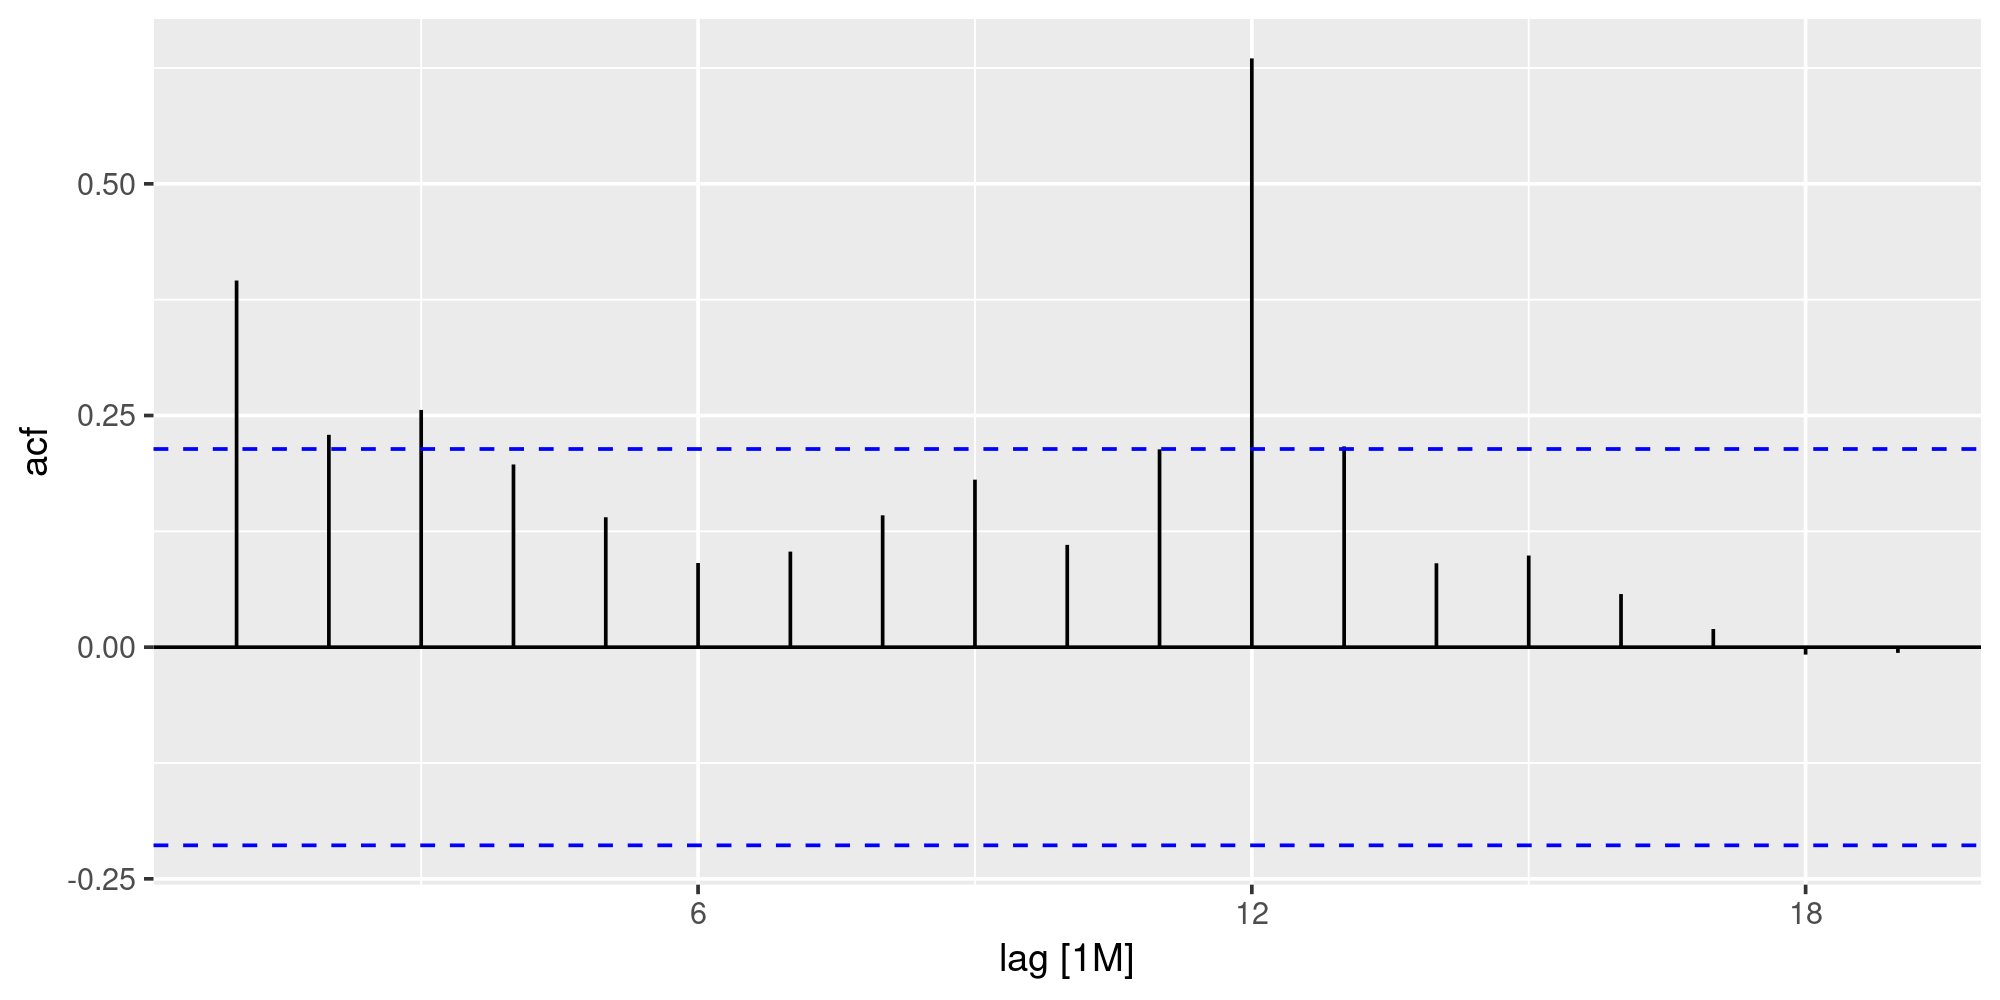

In [9]:
souvenirs |> 
    ACF(Sales) |>
    autoplot()

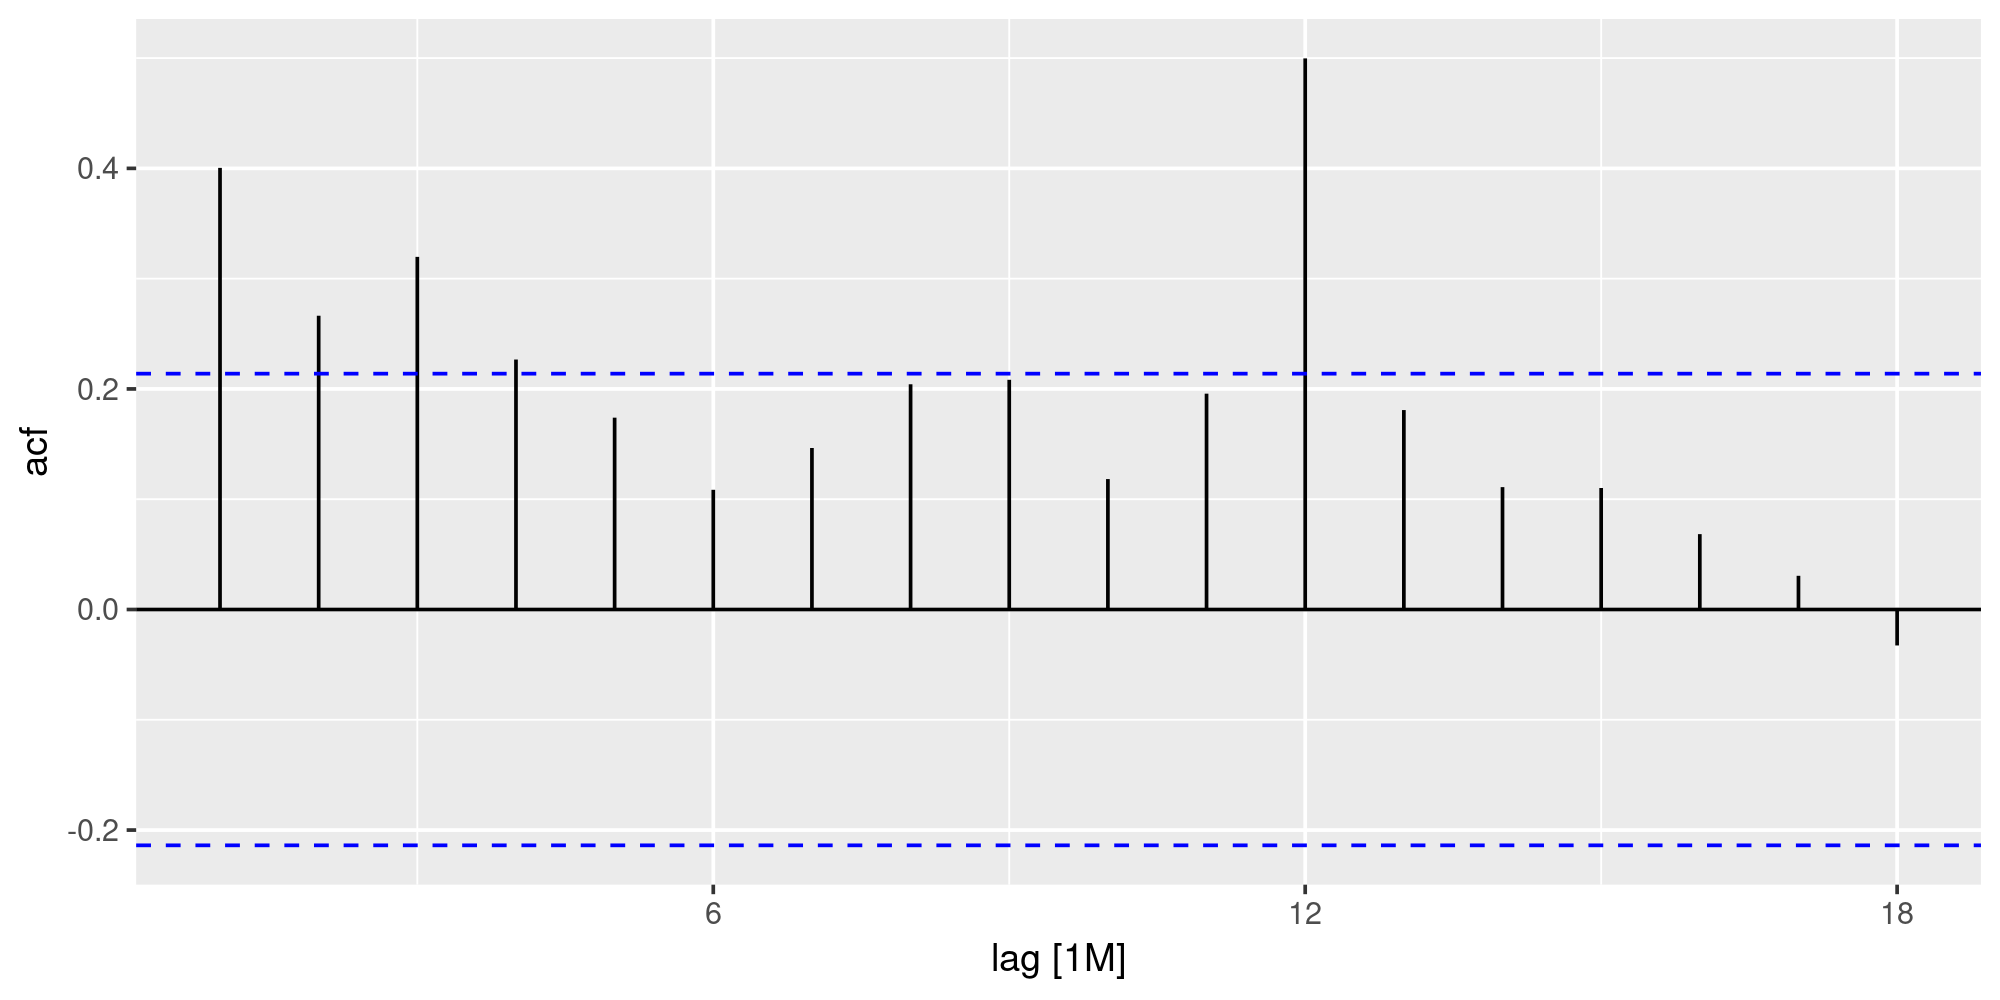

In [10]:
souvenirs |> 
    mutate(Difference = difference(Sales, 12)) |> 
    ACF(Difference) |>
    autoplot()

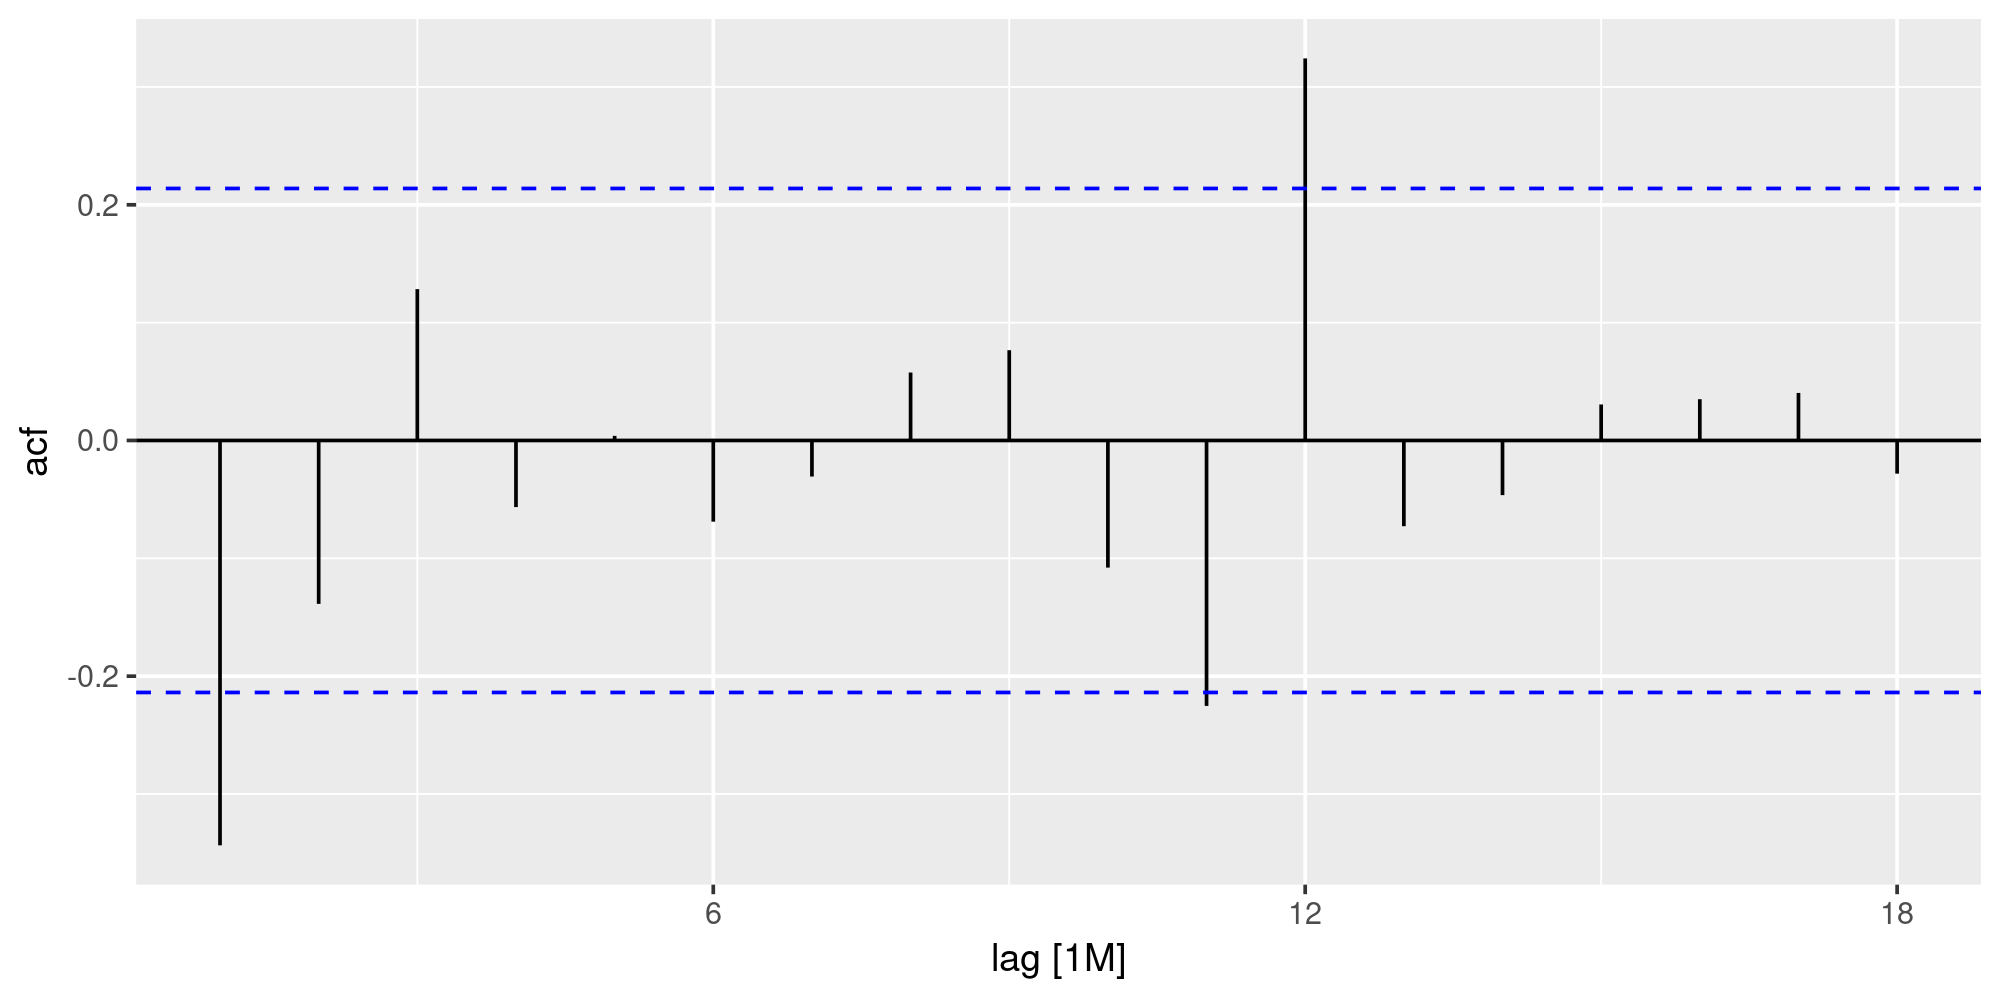

In [11]:
souvenirs |> 
    mutate(Difference = difference(difference(Sales, 12))) |> 
    ACF(Difference) |>
    autoplot()

## More on twice-differences series

If $y'_t = y_t - y_{t-m}$ denotes a seasonally differenced series, then the twice-differenced series is 
\begin{align*}
y''_t &= y'_t - y'_{t-1} \\
      &= (y_t - y_{t-m}) - (y_{t-1} - y_{t-m-1}) \\
      &= y_t -y_{t-1} - y_{t-m} + y_{t-m-1}\:
\end{align*}

When both seasonal and first differences are applied, it makes no difference which is done first—the result will be the same. 

However, if the data have a strong seasonal pattern, it is recommended to do seasonal differencing first, because the resulting series will sometimes be stationary and there will be no need for a further first difference.

## Unit root tests

One way to determine more objectively whether differencing is required is to use a unit root test. These are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required.

Symbol,kpss_stat,kpss_pvalue
<chr>,<dbl>,<dbl>
AAPL,1.47105,0.01


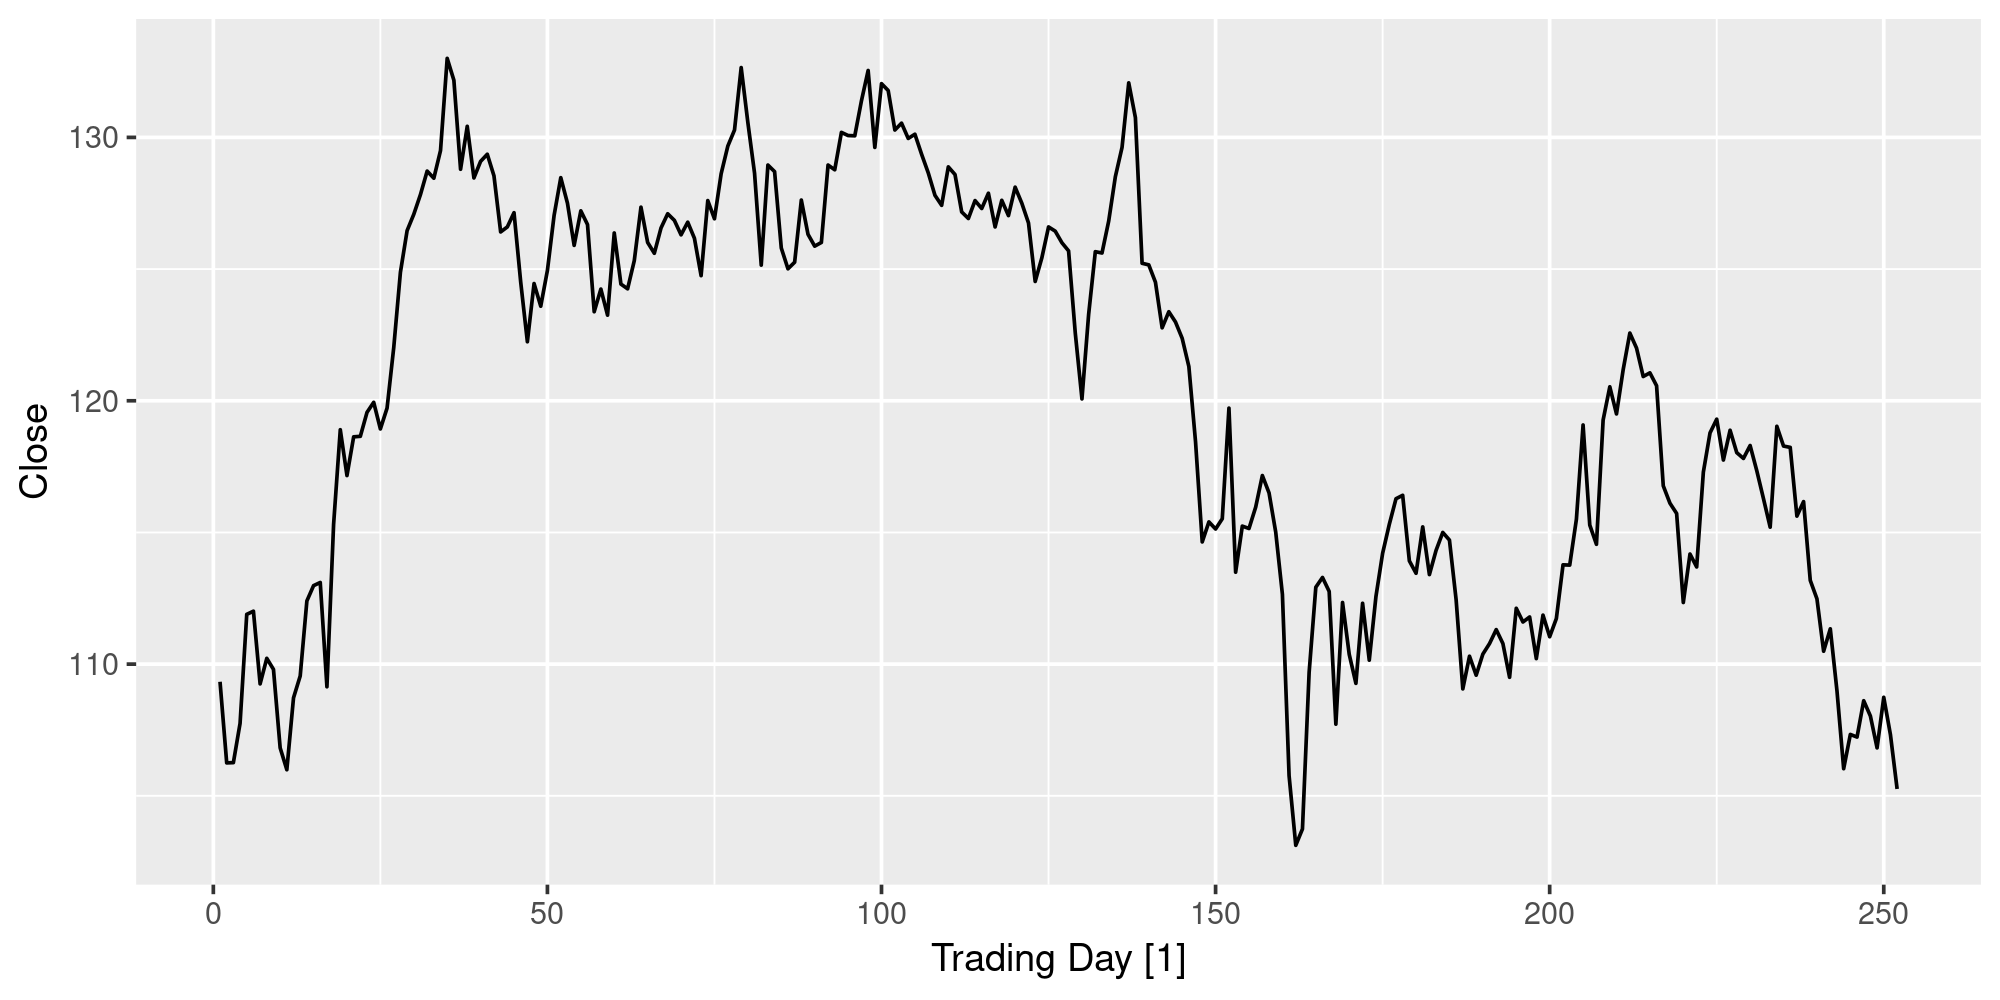

In [12]:
aapl_2015 |>  autoplot(Close)

aapl_2015 |> features(Close, unitroot_kpss)

In this case, the p-value is shown as 0.01, indicating that the null hypothesis is rejected. That is, the data are not stationary.

Symbol,kpss_stat,kpss_pvalue
<chr>,<dbl>,<dbl>
AAPL,0.2819894,0.1


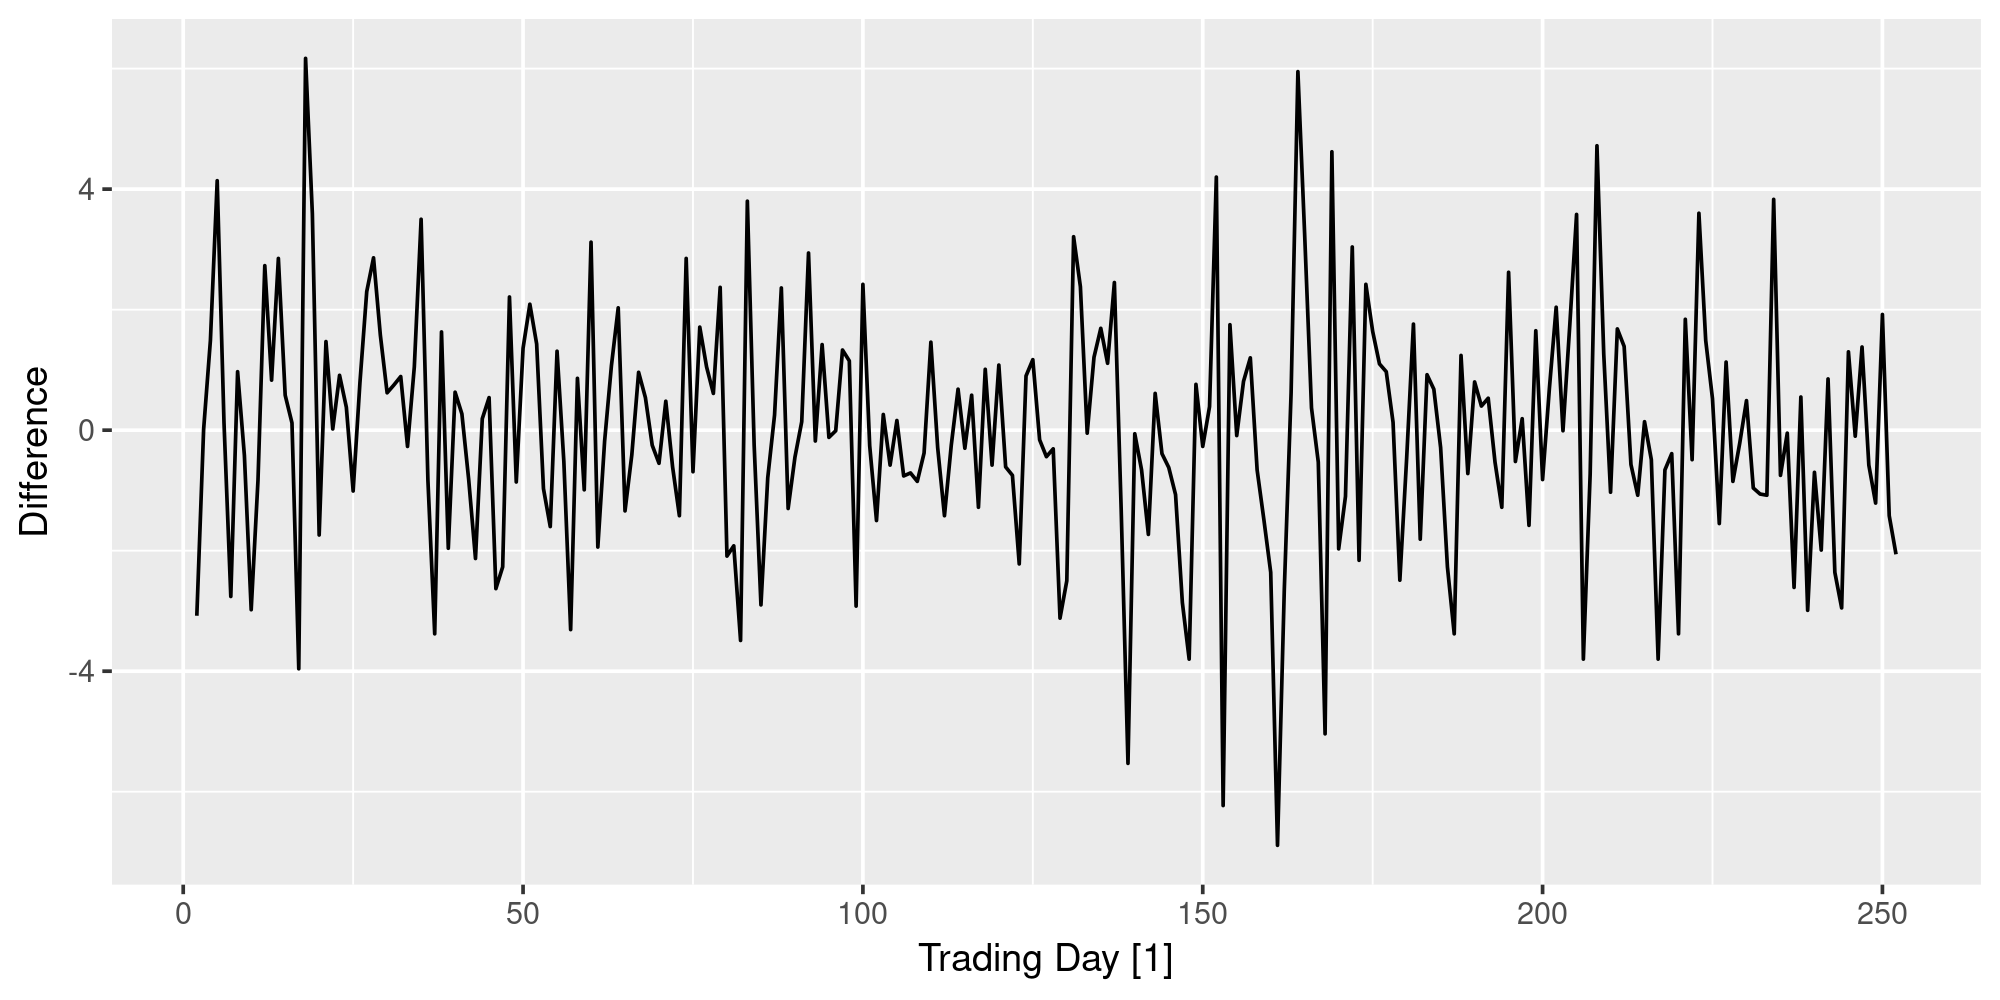

In [13]:
aapl_2015 |> 
    mutate(Difference = difference(Close)) |>
    filter(!is.na(Difference)) |>
    autoplot(Difference)

aapl_2015 |> 
    mutate(Difference = difference(Close)) |>
    features(Difference, unitroot_kpss)

## Determining the number of first differences

This process of using a sequence of KPSS tests to determine the appropriate number of first differences is carried out using the `unitroot_ndiffs()` feature.

In [14]:
aapl_2015 |> 
    features(Close, unitroot_ndiffs)

Symbol,ndiffs
<chr>,<int>
AAPL,1


ndiffs
<int>
0


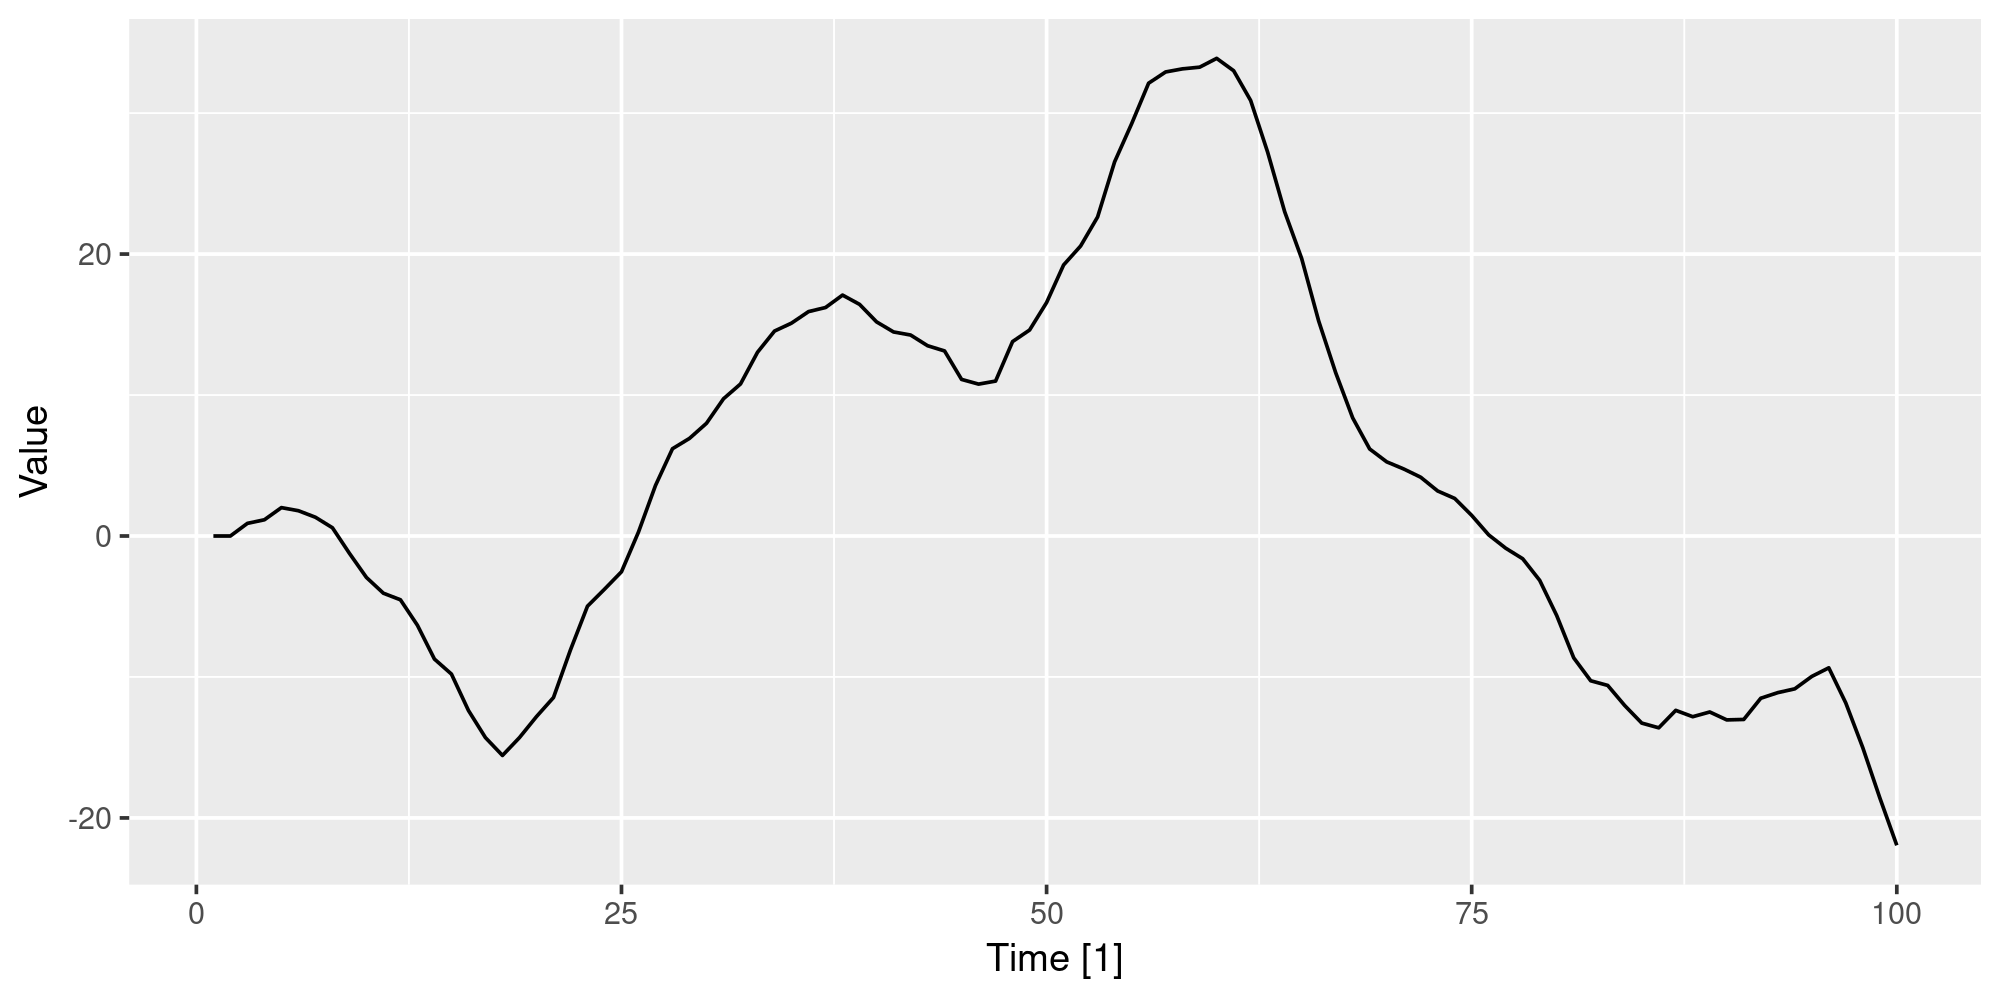

In [15]:
rw2 |> autoplot(Value)
rw2 |> features(Value, unitroot_ndiffs)

## Questions?

## Backshift notation

The backward shift operator $B$ is a useful notational device when working with time series lags: 
$$
B y_{t} = y_{t - 1} \: .
$$

Two applications of $B$ to $y_t$ shifts the data back two periods:
$$B(By_{t}) = B^{2}y_{t} = y_{t-2}\: .$$

## Backshift notation for differencing

A first difference can be written as 
$$y'_{t} = y_{t} - y_{t-1} = y_t - By_{t} = (1 - B)y_{t}\: .$$

Similarly, if second-order differences have to be computed, then: 
$$y''_{t} = y_{t} - 2y_{t - 1} + y_{t - 2} = (1-2B+B^2)y_t = (1 - B)^{2} y_{t}\: .$$

A seasonal difference followed by a first difference can be written as 
\begin{align*}
(1-B)(1-B^m)y_t &= (1 - B - B^m + B^{m+1})y_t \\
&= y_t-y_{t-1}-y_{t-m}+y_{t-m-1},
\end{align*}

## Autoregressive models

- In a multiple regression model, we forecast the variable of interest using a linear combination of predictors.

- In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.

- The term autoregression indicates that it is a regression of the variable against itself.

Autoregressive model of order $p$: 
$$
y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t},
$$
where $\varepsilon_{t}$ is white noise.

## Examples of autoregressive models

Autoregressive models are remarkably flexible at handling a wide range of different time series patterns.

<p align="center">
  <img src="img/arp-1.png" alt="AR(p)" width="600"/>
</p>

Two examples of data from autoregressive models with different parameters. 
- Left: AR(1) with $y_t=18−0.8y_{t−1}+\varepsilon_t$. 
- Right: AR(2) with $y_t=8+1.3y_{t−1}−0.7y_{t−2}+\varepsilon_t$. 

In both cases, $\varepsilon_t$ is normally distributed white noise with mean zero and variance one.

## Special cases of AR(1)

Autoregressive model of order $1$, or AR(1): 
$$
y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t},
$$
where $\varepsilon_{t}$ is white noise.

- when $\phi_{1}=0$ and $c=0$, equivalent to ?
- when $\phi_{1}=1$ and $c=0$, equivalent to ?
- when $\phi_{1}=1$ and $c \neq 0$, equivalent to ?
- when $\phi_{1}<0$, tends to oscillate around the mean

## Simulating AR(1) model

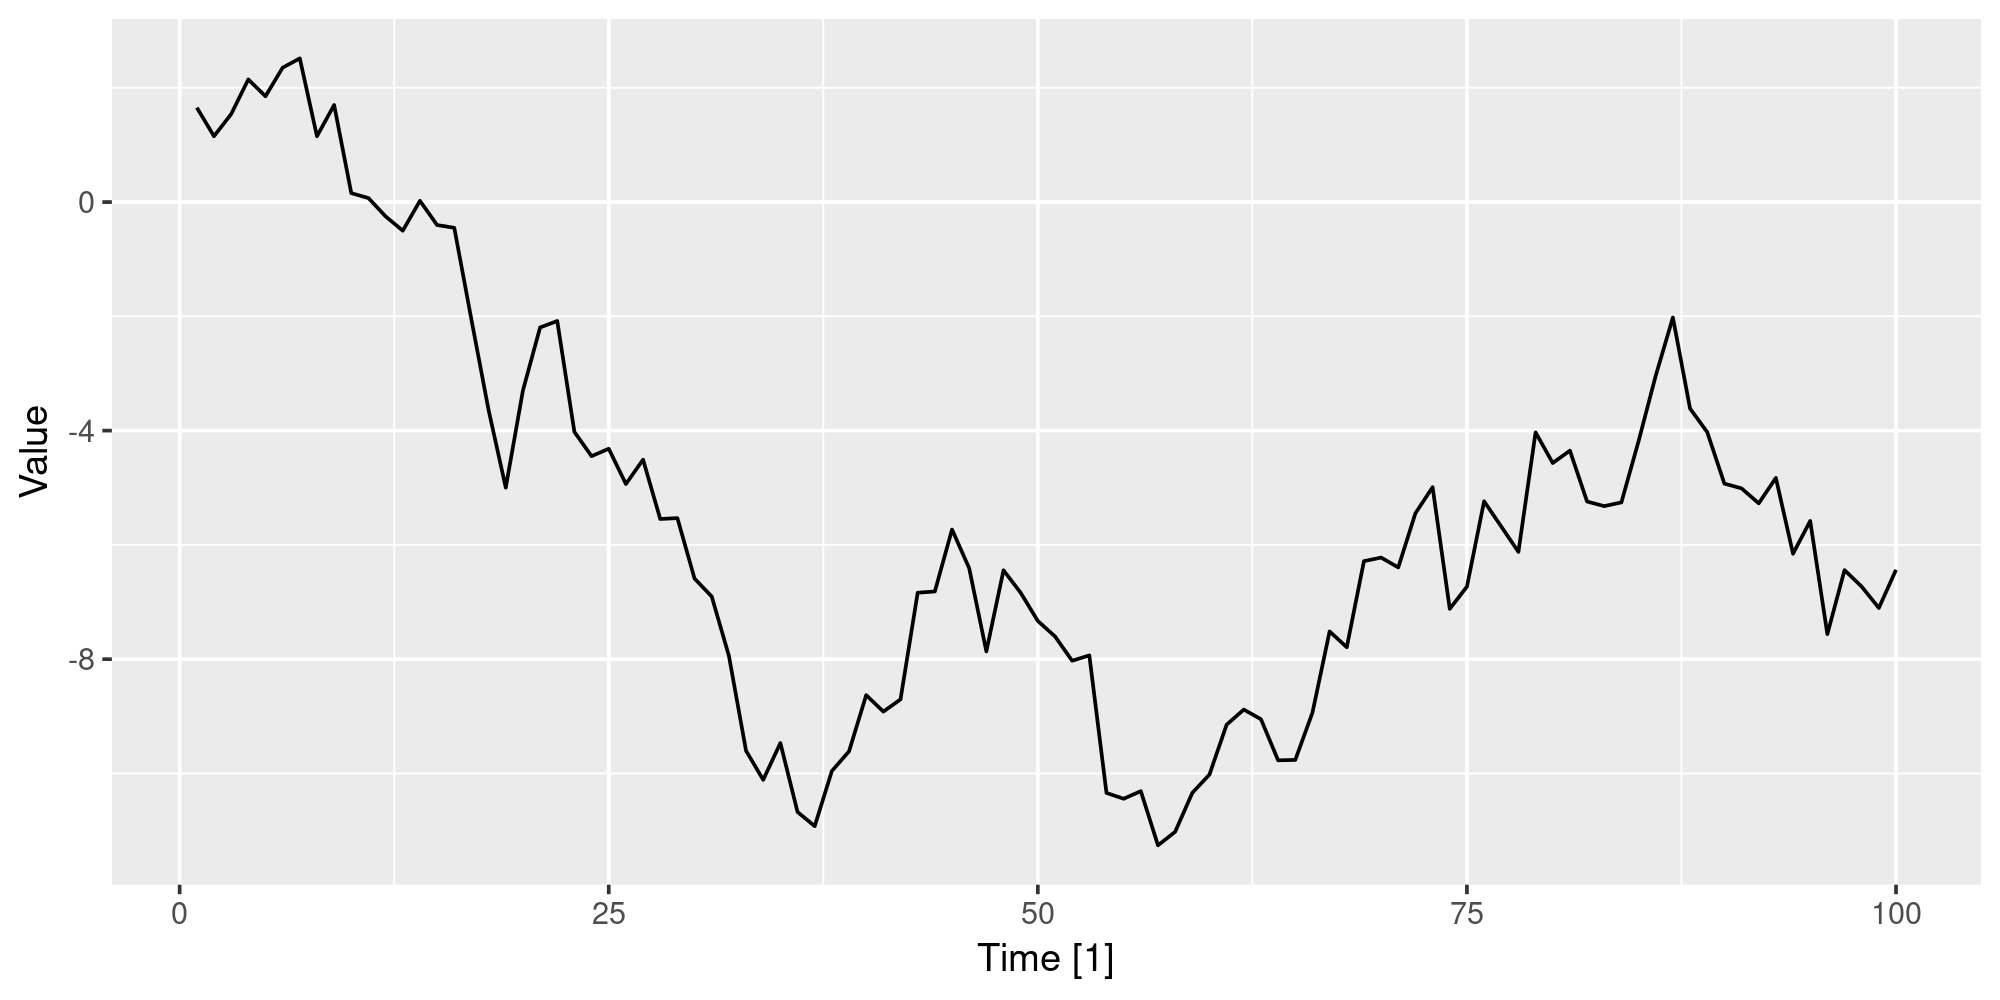

In [16]:
# Function to generate AR(1) time series and return it as a tsibble
generate_ar1 <- function(n, cc=0, phi=0, sigma = 1) {
  # Generate centered white noise (epsilon_t) with mean 0
  epsilon <- rnorm(n, mean = 0, sd = sigma)  
  series <- numeric(n)  # Initialize the time series vector
  series[1] <- epsilon[1] + cc  # Set initial value
  for (t in 2:n) {  # Generate AR(1) time series using the recursive formula
    series[t] <- cc + phi * series[t-1] + epsilon[t]
  }
  # Return the AR(1) series as a tsibble
  tibble(Time = 1:n, Value = series) |> as_tsibble(index = Time)
}

generate_ar1(100, cc=0, phi=1) |> autoplot(Value)

## Stationary AR(p)

We normally restrict autoregressive models to stationary data, in which case some constraints on the values of the parameters are required.

- For AR(1): $-1 < \phi_1 < 1$
- For AR(2): $-1 < \phi_2 < 1$ and $\phi_1 + \phi_2 < 1$ and $\phi_2-\phi_1 < 1$

When $p \geq 3, the restrictions are much more complicated. 

The `fable` package takes care of these restrictions when estimating a model.

## Moving average models

A moving average model of order $q$, namely MA(q), uses past forecast errors in a regression-like model, 
$$
y_{t} = c + \varepsilon_t + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q},
$$
where $\varepsilon_t$  is white noise.

<p align="center">
  <img src="img/maq-1.png" alt="MA(q)" width="600"/>
</p>

Two examples of data from autoregressive models with different parameters. 
- Left: MA(1) with $y_t=20+\varepsilon_t + 0.8\varepsilon_{t-1}$. 
- Right: MA(2) with $y_t=\varepsilon_t-\varepsilon_{t-1}+0.8\varepsilon_{t-2}$. 

In both cases, $\varepsilon_t$ is normally distributed white noise with mean zero and variance one.

## Relation between AR(p) and MA(q)

- It is possible to write any stationary AR(p) model as an MA($\infty$) model.

- The reverse result holds if we impose some constraints on the MA parameters. Then the MA model is called *invertible*. We can write any invertible MA(q) process as an AR($\infty$) process.

The invertibility constraints are similar to the stationarity constraints.
- For MA(1): $-1 < \theta_1 < 1$
- For MA(2): $-1 < \theta_2 < 1$ and $\theta_1 + \theta_2 < 1$ and $\theta_2-\theta_1 < 1$

More complicated conditions hold for $q \geq 3$. Again, the `fable` package will take care of these constraints when estimating the models.

## Non-seasonal ARIMA models

Differencing + AR(p) + MA(q) $\Rightarrow$ *non-seasonal ARIMA model*.

ARIMA is an acronym for AutoRegressive Integrated Moving Average (in this context, “integration” is the reverse of differencing)

The full model can be written as 
\begin{equation}
  y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p}
     + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t},
\end{equation}

where $y'_t$ is the differenced series (it may have been differenced more than once).

We call this an ARIMA(p,d,q) model, where
- $p$ = order of the autoregressive part;
- $d$ = degree of first differencing involved;
- $q$ = order of the moving average part.

## Special cases of ARIMA models

- White noise $\qquad$ ARIMA(0,0,0) with no constant
- Random walk $\qquad$ 	ARIMA(0,1,0) with no constant
- Random walk with drift $\qquad$ 	ARIMA(0,1,0) with a constant
- Autoregression $\qquad$ 	ARIMA(p,0,0)
- Moving average $\qquad$ 	ARIMA(0,0,q

## Backshift notation for ARIMA models

ARIMA(p,d,q):
\begin{equation}
  y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p}
     + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}
\end{equation}
can be written as:
\begin{equation}
  \begin{array}{c c c c}
    (1-\phi_1B - \cdots - \phi_p B^p) & (1-B)^d y_{t} &= &c + (1 + \theta_1 B + \cdots + \theta_q B^q)\varepsilon_t\\
    {\uparrow} & {\uparrow} & &{\uparrow}\\
    \text{AR($p$)} & \text{$d$ differences} & & \text{MA($q$)}\\
  \end{array}
\end{equation}

## Fitting ARIMA models

Selecting appropriate values for $p$, $d$ and $q$ for a given time series can be difficult. 

However, the `ARIMA()` function from the `fable` package will do it for you automatically.

We will learn how this function works next week.

## Example: United States exports

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


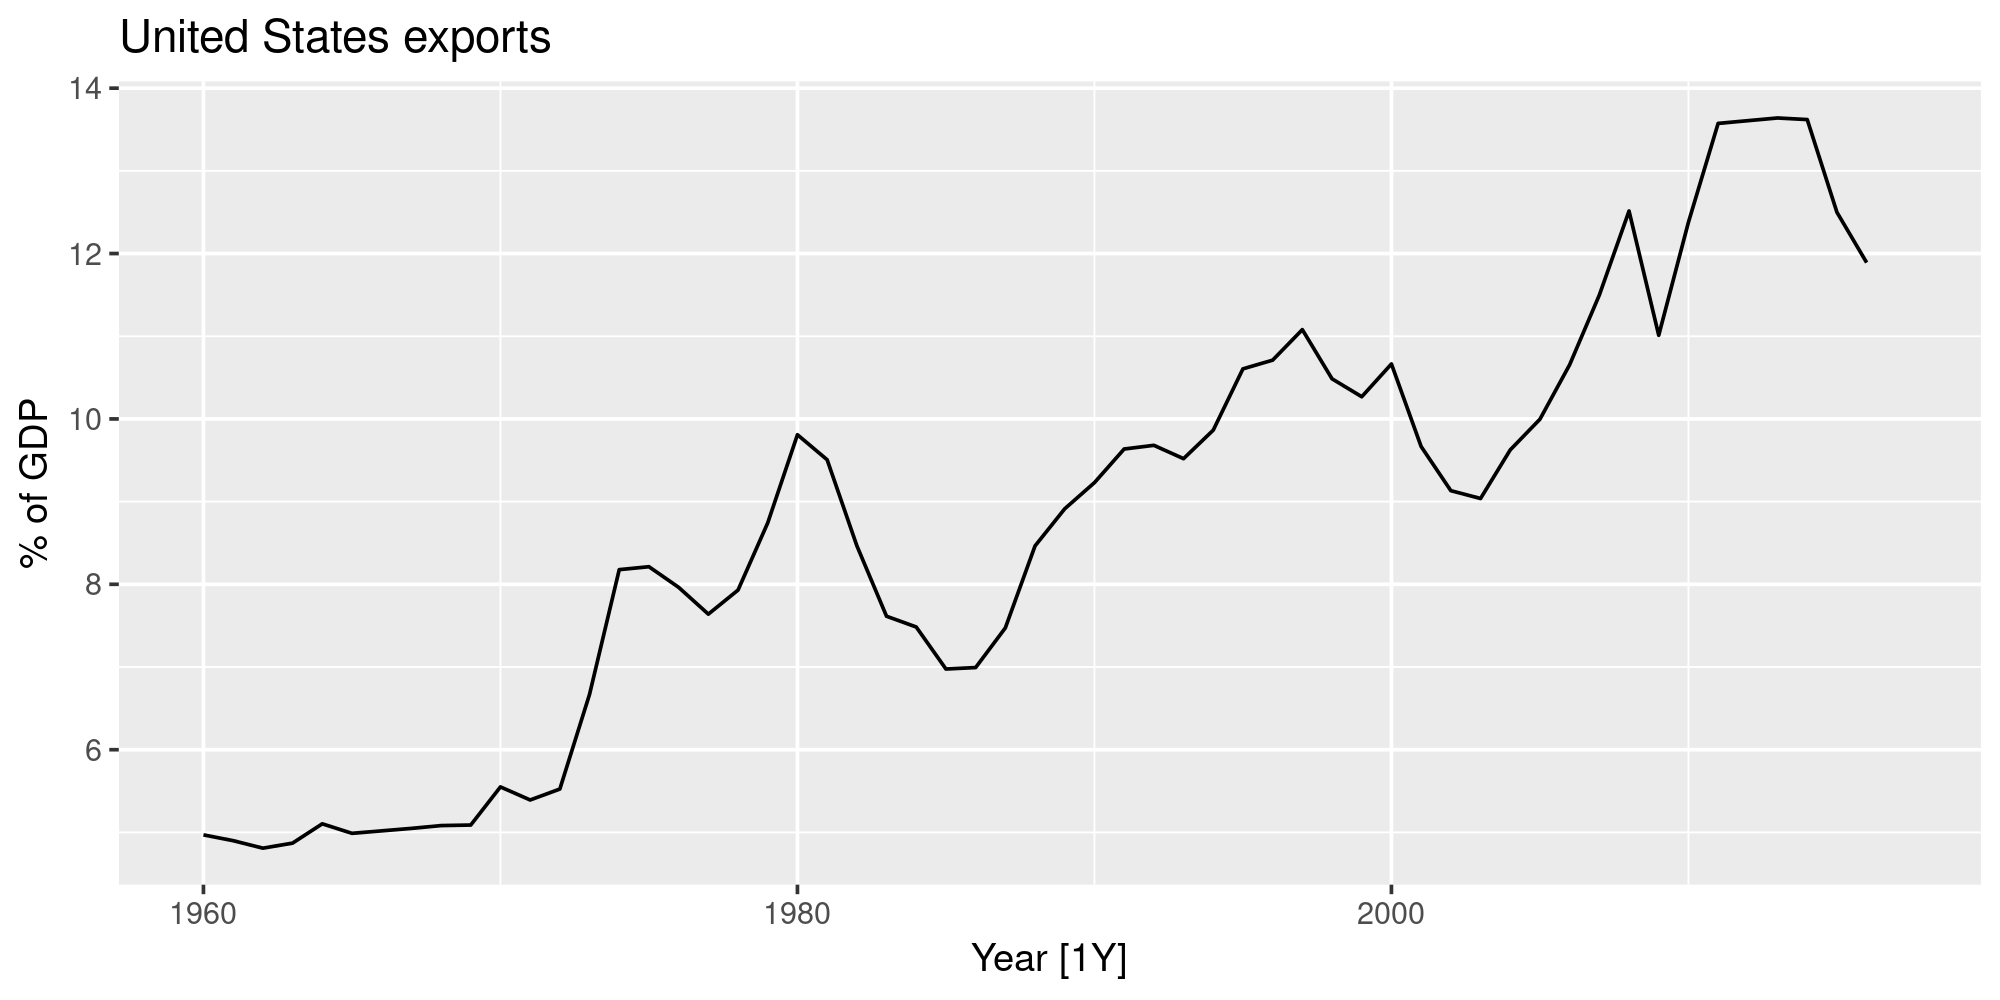

In [17]:
global_economy |> filter(Code == "USA") |>
  autoplot(Exports) +
  labs(y = "% of GDP", title = "United States exports")

The following R code selects a non-seasonal ARIMA model automatically.

In [18]:
fit <- global_economy |> filter(Code == "USA") |>
    model(ARIMA(Exports))

report(fit)

Series: Exports 
Model: ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3193
s.e.  0.1258

sigma^2 estimated as 0.3633:  log likelihood=-51.17
AIC=106.33   AICc=106.55   BIC=110.42


This is an ARIMA(p=0,d=1,q=1) model.

What is ARIMA(p=0,d=1,q=1)?

\begin{equation}
  y'_{t} = c + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t},
\end{equation}
or
\begin{equation}
  \begin{array}{c c c c}
    (1-B) y_{t} &= &c + (1 + \theta_1 B)\varepsilon_t\\
    {\uparrow} & {\uparrow} & &{\uparrow}\\
    \text{$1$ difference} & & \text{MA($1$)}\\
  \end{array}
\end{equation}

## ACF and PACF plots

It is usually not possible to tell, simply from a time plot, what values of $p$ and $q$ are appropriate for the data. 

However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for $p$ and $q$.

**Partial autocorrelations** measure the relationship between $y_t$ and $y_{t−k}$ after removing the effects of lags $1,2,3,\ldots,k-1$.

The first partial autocorrelation is identical to the first autocorrelation, because there is nothing between them to remove. 

## Partial autocorrelations (example)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


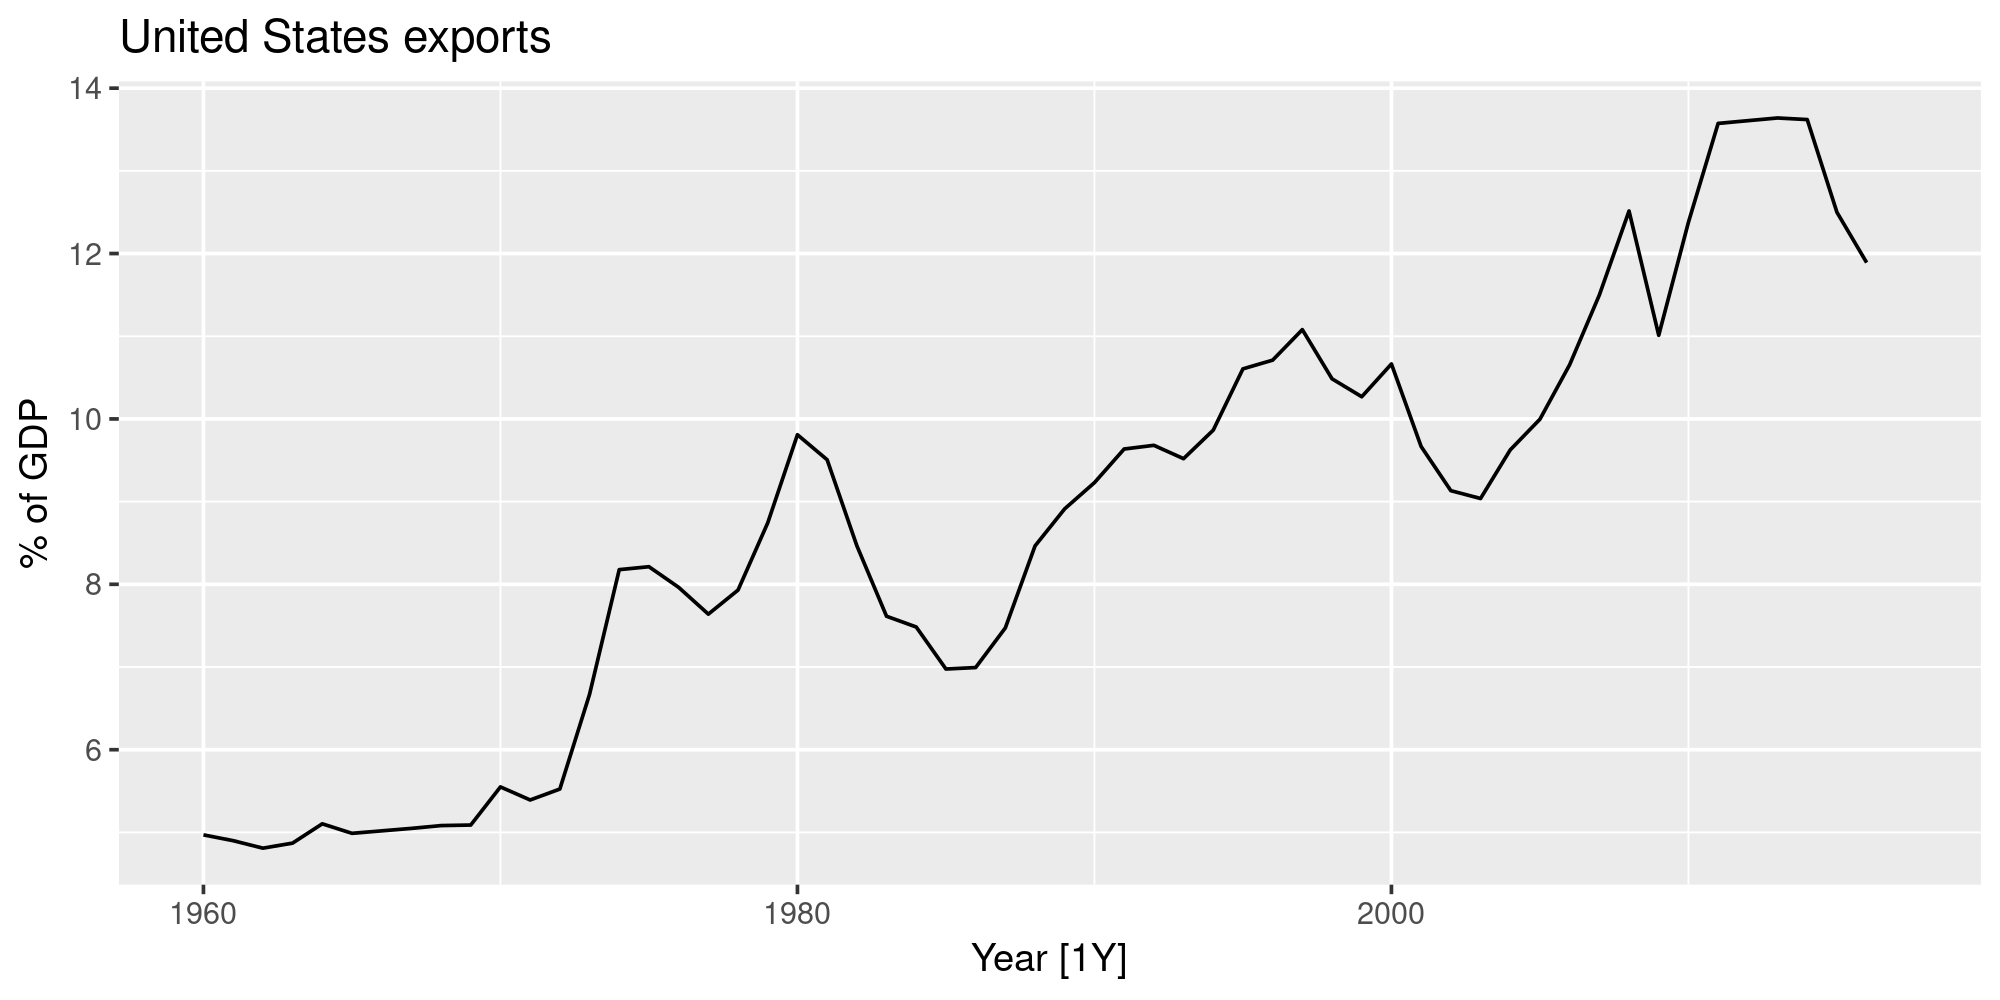

In [19]:
global_economy |> filter(Code == "USA") |>
  autoplot(Exports) +
  labs(y = "% of GDP", title = "United States exports")

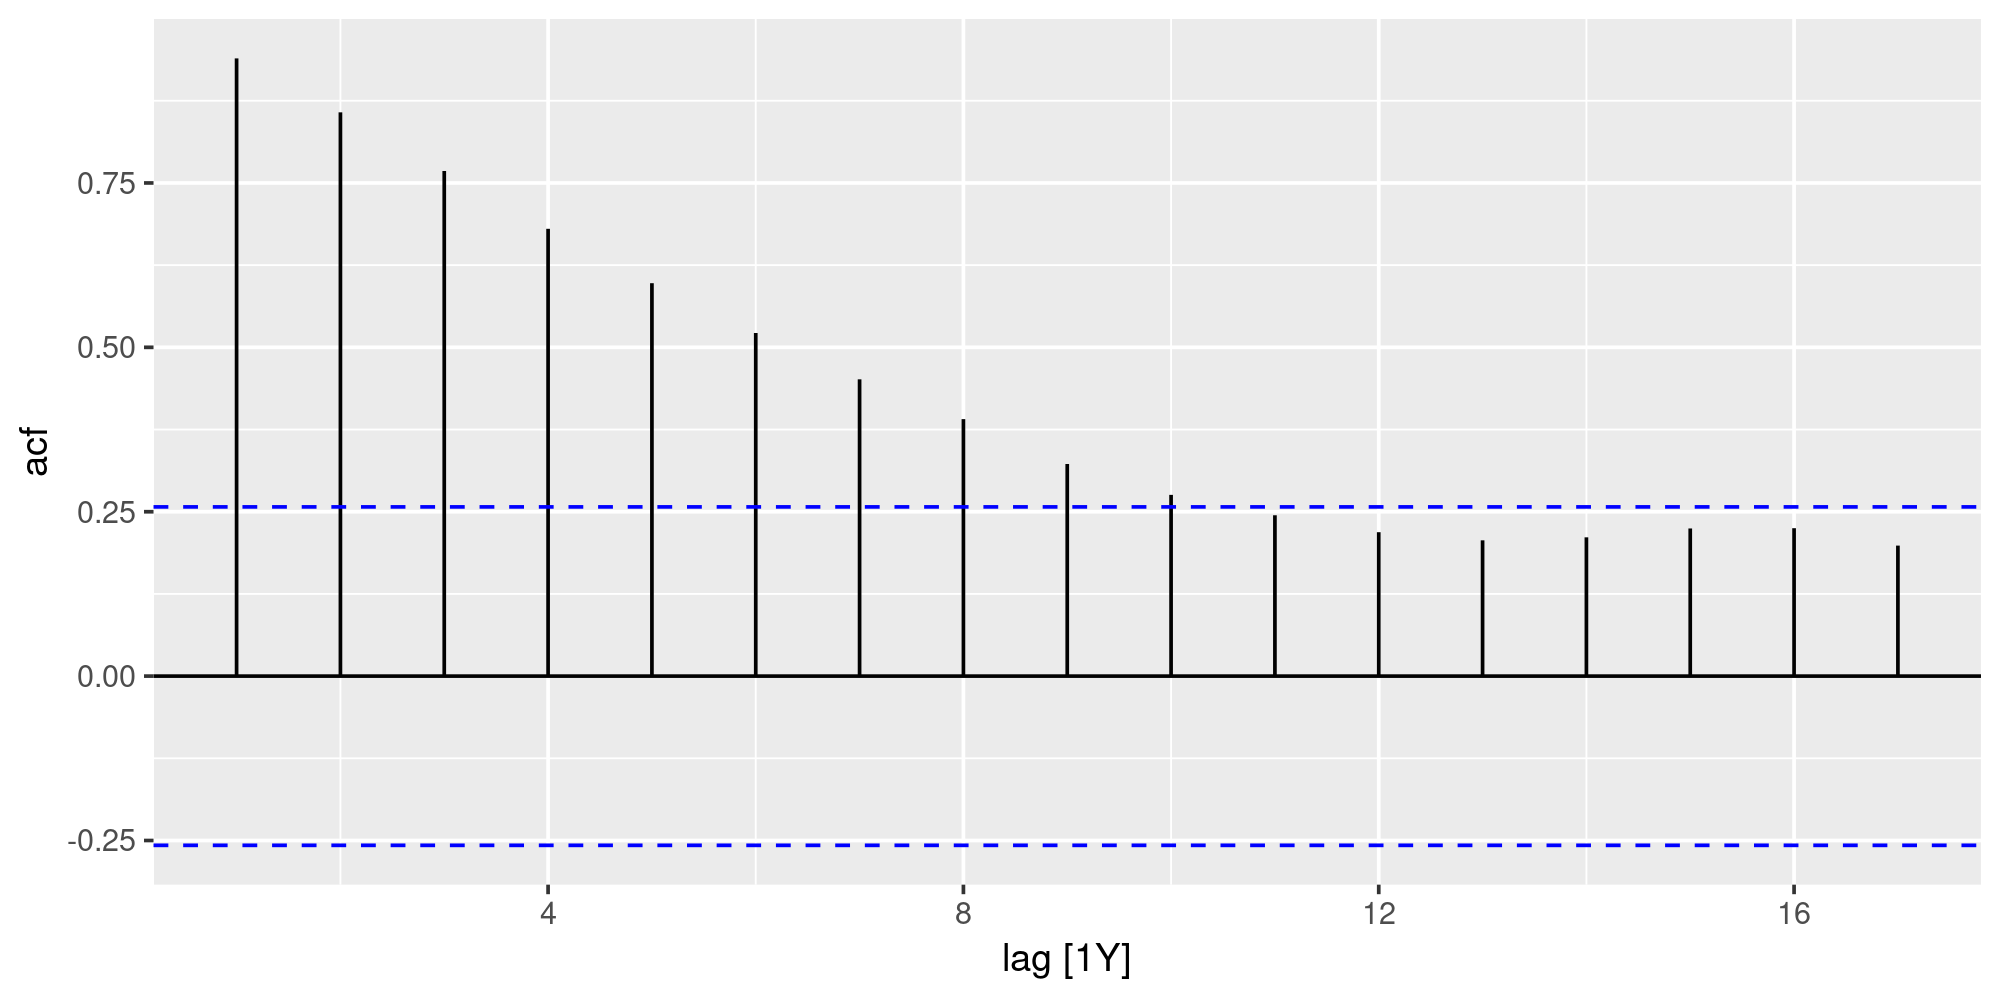

In [20]:
global_economy |> filter(Code == "USA") |>
  ACF(Exports) |>
  autoplot()

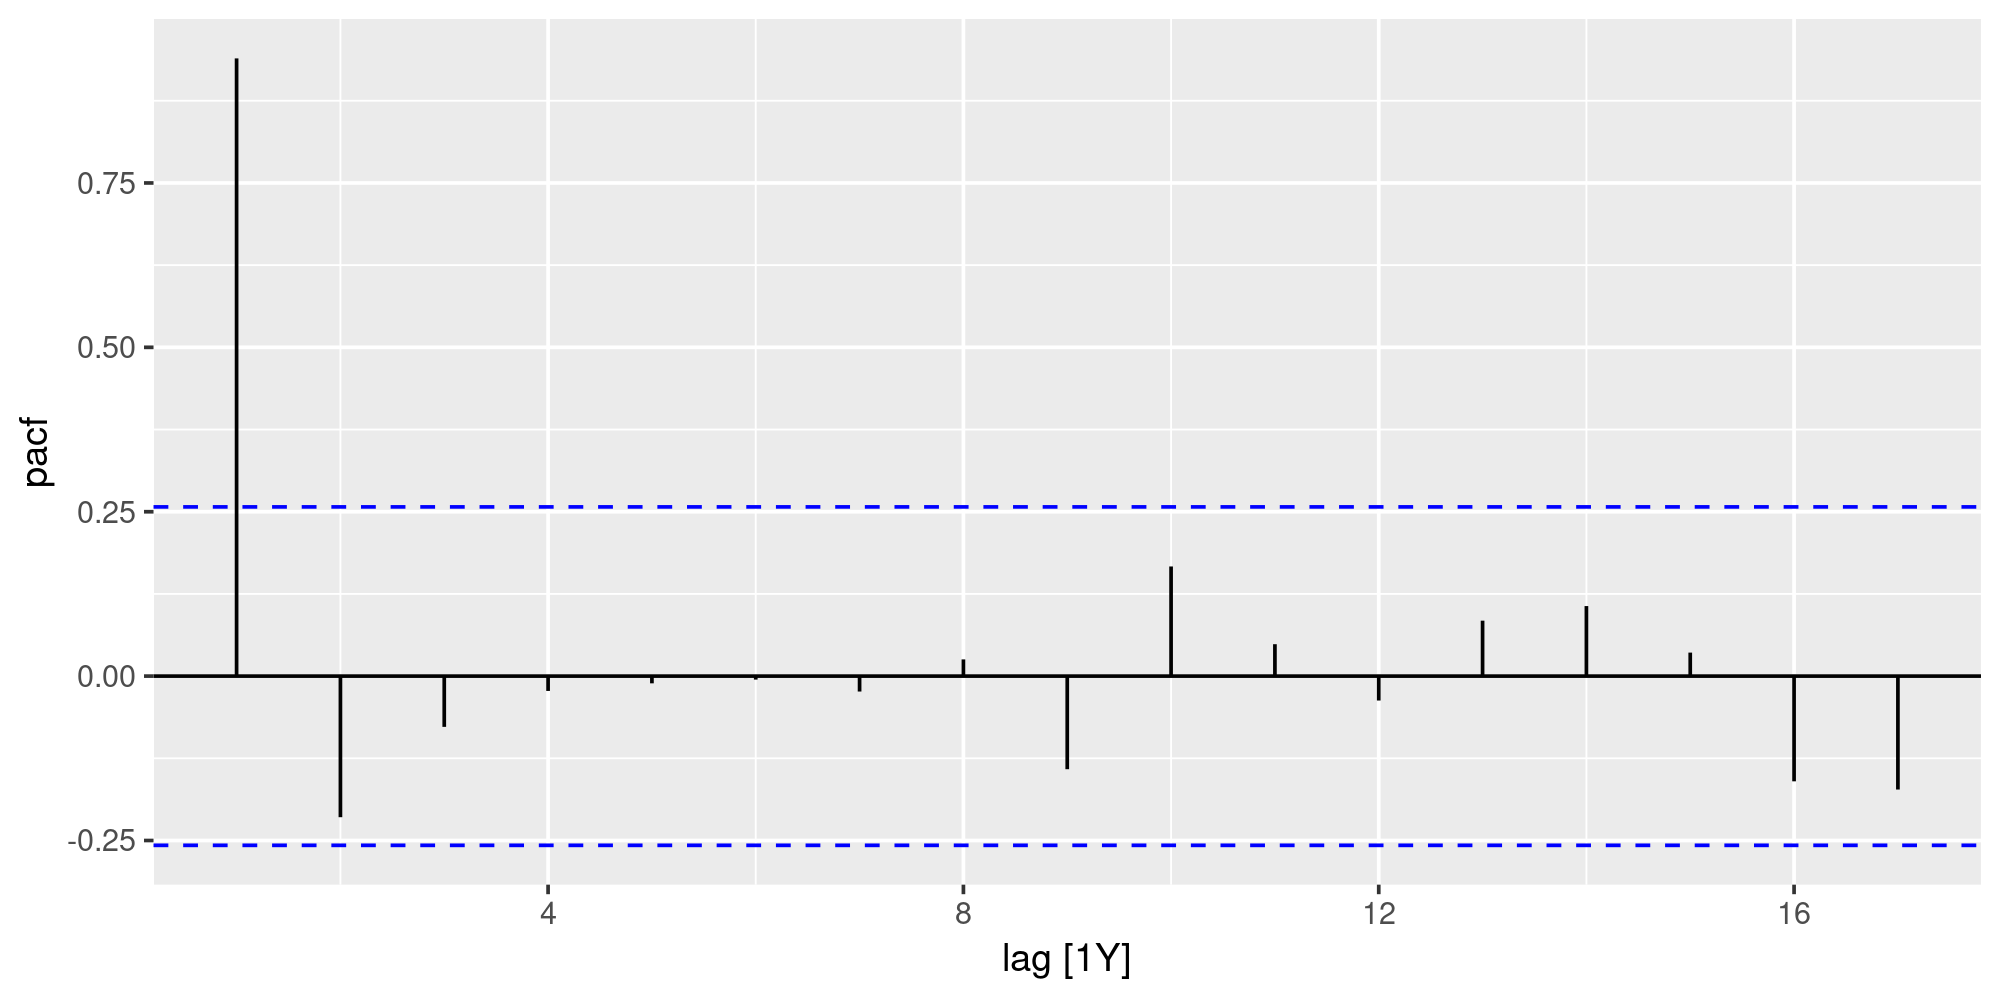

In [21]:
global_economy |> filter(Code == "USA") |>
  PACF(Exports) |>
  autoplot()

## Using PACF to understand ARIMA

If the data are from an ARIMA(p,d,0) or ARIMA(0,d,q) model, then the ACF and PACF plots can be helpful in determining the value of $p$ or $q$. 

If $p$ and $q$ are both positive, then the plots do not help in finding suitable values of $p$ and $q$.

## Using PACF to find $p$ or $q$

The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

- the ACF is exponentially decaying or sinusoidal;

- there is a significant spike at lag $q$ in the PACF, but none beyond lag $q$.

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

- the PACF is exponentially decaying or sinusoidal;

- there is a significant spike at lag $q$ in the ACF, but none beyond lag $q$.

## Next time

More on fitting ARIMA models and using them to make forecasts.